# Компьютер говорит "Нет" 

**Суть проекта — написать скоринговую модель предсказания дефолта клиентов банка.**.

Cделать это можно с помощью модели кредитного скоринга для вторичных клиентов.. Предоставлена информация из анкетных данных заемщиков и факт наличия дефолта.

Датасет содержит переменные:
- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

# 1. Первичная обработка данных.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import seaborn as sns
from itertools import combinations


import scipy
from scipy import stats
from scipy.stats import ttest_ind

# Задаем некоторые опции библиотеки pandas, которые
# настраивают вывод

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 80)

In [2]:
import datetime
from datetime import datetime, date

In [3]:
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, mean_squared_error, f1_score, accuracy_score

from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_score, recall_score

# warnings.filterwarnings("ignore")  # Убирает некритические сообщения

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [6]:
# зафиксируем RANDOM_SEED, чтобы  эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [7]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [8]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [9]:
#df_train = pd.read_csv('train.csv', encoding='cp1251', sep=',')
#df_test = pd.read_csv('test.csv', encoding='cp1251', sep=',')

In [10]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['default'] = 0

df = df_test.append(df_train, sort=False).reset_index(drop=True)  # объединяем

In [11]:
data = df_train

In [12]:
# смотрим форму датафрейма
data.shape

(73799, 20)

In [13]:
df.shape

(110148, 20)

In [14]:
# проверяем, успешно ли импортируются данные
display(data.head(5))

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1


In [15]:
# проверим все ли столбцы, что есть в описании загрузились
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

**Вывод:**
- загрузилось 20 столбцов, в соответствии с описанием
- всего 73799 записей

# 2. Первичный анализ данных в столбцах 

In [16]:
# посмотрим как записаны столбцы
df.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'sample', 'default'],
      dtype='object')

## Дубли и пропуски в данных

In [17]:
# если есть дублирующие строки,то удаляем, оставив последнее из дублирующихся наблюдений
df.drop_duplicates(keep='last')
# удаляем те строки, в которых все значения являются значениями NaN
df.dropna(how='all')
# попрощаемся со столбцами,  в которых все значения являются значениями NaN
df.dropna(how='all', axis=1)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,1,0
110144,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,1,0
110145,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,1,0
110146,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1,1


In [18]:
# смотрим форму датафрейма
df.shape

(110148, 20)

Количество строк и столбцов не изменилось. 
Дублирующих строк нет. Колонок и строк полностью из пропусков нет

In [19]:
# выводим информацию о количестве пропусков
data.isnull().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
sample                0
dtype: int64

In [20]:
# выводим информацию о количестве пропусков
df.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

Пропуски в колонке education (уровень образования). 

In [21]:
# Посмотрим количество пропусков в процентах, так нагляднее
data_null = round(data.isnull().sum() / len(data)*100, 2)
print(data_null)

client_id           0.00
app_date            0.00
education           0.42
sex                 0.00
age                 0.00
car                 0.00
car_type            0.00
decline_app_cnt     0.00
good_work           0.00
score_bki           0.00
bki_request_cnt     0.00
region_rating       0.00
home_address        0.00
work_address        0.00
income              0.00
sna                 0.00
first_time          0.00
foreign_passport    0.00
default             0.00
sample              0.00
dtype: float64


In [22]:
# Посмотрим количество пропусков в процентах, так нагляднее
df_null = round(df.isnull().sum() / len(df)*100, 2)
print(df_null)

client_id           0.00
app_date            0.00
education           0.43
sex                 0.00
age                 0.00
car                 0.00
car_type            0.00
decline_app_cnt     0.00
good_work           0.00
score_bki           0.00
bki_request_cnt     0.00
region_rating       0.00
home_address        0.00
work_address        0.00
income              0.00
sna                 0.00
first_time          0.00
foreign_passport    0.00
sample              0.00
default             0.00
dtype: float64


Колонка education количество незаполненных значений 0,43%. 

<AxesSubplot:>

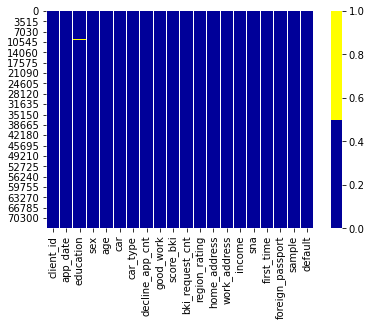

In [23]:
# Посмотрим с помощью тепловой карты на пропущенные значения
cols = df.columns
# определяем цвета
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00']
sns.heatmap(data[cols].isnull(), cmap=sns.color_palette(colours))

In [24]:
len(df.dropna(axis=0, how='any'))

109670

109670 строк не содержат пропусков (99,57%). 

Можно воспользоваться методом принудительного заполнения пропусков или удалить строки. 
Для категориальных признаков можно использовать в качестве заполнителя наиболее часто встречающееся значение или выделить в отдельный признак. Но для получения максимально качественно подготовленного набора данных,  вдумчиво посмотрим на признак, поэтому код выполнять пока не будем.

##   Рассмотрим бинарные признаки: 

- **sex** — пол клиента ('F' - женский, 'M' - мужской)
- **car** — наличие автомобиля ('N'- нет, 'Y' да)
- **car_type** — наличие автомобиля иномарки ('N'- нет, 'Y' да)
- **foreign_passport** — наличие загранпаспорта ('N'- нет, 'Y' да)
- **good_work** — наличие «хорошей» работы ('0'- нет, '1' да)

In [25]:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']

### sex — пол клиента ('F' - женский, 'M' - мужской)

In [26]:
pd.DataFrame(data.sex.value_counts())

,sex
F,41562
M,32237


In [27]:
# Посмотрим количество в процентах, так нагляднее
sex_ratio = round(pd.DataFrame(data.sex.value_counts()) / len(data)*100, 2)
print(sex_ratio)

     sex
F  56.32
M  43.68


Посмотрим, как распределены кредиты между мужчинами и женщинами. А также посмотрим, как обстоят дела с возвратом кредитов среди них.

In [28]:
dataMen = data[data['sex'] == 'M']
dataWoman = data[data['sex'] == 'F']

quntityRepaymentMen = len(dataMen[dataMen['default'] == 0])
quntityLoanMen = len(dataMen[dataMen['default'] == 1])
quntityRepaymentWomen = len(dataWoman[dataWoman['default'] == 0])
quntityLoanWomen = len(dataWoman[dataWoman['default'] == 1])

N = 2
repaymentMenWoman = (quntityRepaymentMen, quntityRepaymentWomen)
loanMenWoman = (quntityLoanMen, quntityLoanWomen)

ind = np.arange(N)
width = 0.35

In [29]:
# тут график и он не загружается здесь
#plt.figure(figsize(16, 4))

#sns.set_style("white")

#sns.barplot(x=ind, y=repaymentMenWoman, color="lightcoral")
#sns.barplot(x=ind, y=loanMenWoman, color="lightskyblue",
#            bottom=repaymentMenWoman)

#bar1 = plt.Rectangle((0, 0), 1, 1, fc="lightskyblue", edgecolor='none')
#bar2 = plt.Rectangle((0, 0), 1, 1, fc='lightcoral',  edgecolor='none')
#l = plt.legend([bar1, bar2], [u'Кредиты, в которых есть просрочки по возврату',
#                              u'Кредиты, в которых нет просрочек по возврату'], loc=1, ncol=2, prop={'size': 10})
#plt.title(u'Кредиты, в зависимости от пола')
#plt.xticks(ind, (u'Мужчины', u'Женщины'))
#plt.ylabel(u'Всего выдано кредитов, шт.')
#plt.grid(True)

Проверка гипотезы сводится к проверке следующих утверждений:

$H_0\colon p_1 = p_2$ - доли одинаковы

$H_1\colon p_1 \neq\ p_2$ - доли разные

Для этого воспользуемся Z-критерием для разности долей в независимых выборках.

In [30]:
def proportions_diff_confint_ind(sample1, sample2, alpha=0.05):
    z = scipy.stats.norm.ppf(1 - alpha / 2.)

    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)

    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1) /
                                            len(sample1) + p2 * (1 - p2) / len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1) /
                                             len(sample1) + p2 * (1 - p2) / len(sample2))

    return (left_boundary, right_boundary)


def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)

    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2
    P = float(p1*n1 + p2*n2) / (n1 + n2)

    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))


def proportions_diff_z_test(z_stat, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")

    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))

    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [31]:
menList = data[data.sex == 'M'].default.tolist()
womanList = data[data.sex == 'F'].default.tolist()

In [32]:
proportions_diff_confint_ind(menList, womanList)

(0.00830079129008915, 0.018039636621097616)

In [33]:
proportions_diff_z_test(proportions_diff_z_stat_ind(menList, womanList))

9.843671078257898e-08

In [34]:
print(
    "95%% доверительный интервал разницы долей (кредит без просрочек/кредит с просрочками) между мужчинами и женщинами: [%f, %f]" % proportions_diff_confint_ind(menList, womanList))

95% доверительный интервал разницы долей (кредит без просрочек/кредит с просрочками) между мужчинами и женщинами: [0.008301, 0.018040]


In [35]:
print("p-value: ", proportions_diff_z_test(proportions_diff_z_stat_ind(menList, womanList)))

p-value:  9.843671078257898e-08


95% доверительный интервал разницы долей (кредит без просрочек/кредит с просрочками) между мужчинами и женщинами: [0.0083, 0.0180]     
p-value:  9.843671078257898e-08

**sex** - пол клиента (M - мужской, F - женский) в наборе данных представлен 43.68% мужчинами и 56.32% женщинами.

Доли (кредит без просрочек/кредит с просрочками) между мужчинами и женщинами статистически различаются (p-value < 0.05). В тоже время эта разница с практической точки зрения является мизерной (от 0,8% до 1,8%). Поэтому признак sex при построении модели можно считать незначимым. Но думаю надо посмотреть его еще в связи с возрастом и доходом.

In [36]:
# Обозначаем значения с M - мужской как 1, F - женский как ноль.
data['sex'] = data['sex'].apply(lambda x: 1 if x == 'M' else 0)
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'M' else 0)

### car — наличие автомобиля ('N'- нет, 'Y' да)

In [37]:
pd.DataFrame(data.car.value_counts())

,car
N,49832
Y,23967


In [38]:
# Посмотрим количество в процентах, так нагляднее
sex_ratio = round(pd.DataFrame(data.car.value_counts()) / len(data)*100, 2)
print(sex_ratio)

     car
N  67.52
Y  32.48


Text(0.5, 1.0, 'Кредиты с дефолтом, в зависимости от наличие автомобиля')

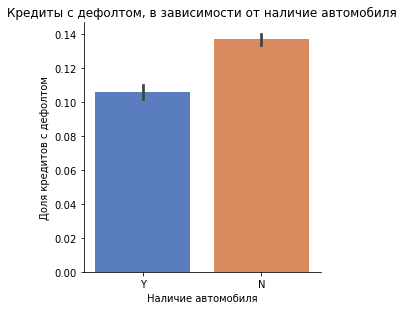

In [39]:
# среднее значение внутри каждой категории и отобразим ее доверительный интервал:
sns.catplot(x='car', y='default',  data=data,
            kind="bar", palette="muted", height=4)
plt.ylabel(u'Доля кредитов с дефолтом')
plt.xlabel(u'Наличие автомобиля')
plt.title(u'Кредиты с дефолтом, в зависимости от наличие автомобиля')

In [40]:
tablecar = pd.DataFrame({u'Без дефолта': data[data['default'] == 0].car.value_counts(
), u'С дефолтом': data[data['default'] == 1].car.value_counts()})
tablecar

,Без дефолта,С дефолтом
N,43007,6825
Y,21420,2547


**car** - 67.52% (49 832 человека) не имеют автомобиля. Из них 13.7% (6 825 из 49 832) имеют невозврат кредита. Имеют автомобиль 32.5% (23 967). Разница в 3.1%. Среди них невозвратов 10.6% (2 547 из 23 967). Поэтому признак car при построении модели можно считать значимым.

In [41]:
# Обозначаем значения Y как 1, остальные как ноль.
data['car'] = data['car'].apply(lambda x: 1 if x == 'Y' else 0)
df['car'] = df['car'].apply(lambda x: 1 if x == 'Y' else 0)

### car_type — наличие автомобиля иномарки ('N'- нет, 'Y' да)

In [42]:
pd.DataFrame(data.car_type.value_counts())

,car_type
N,59791
Y,14008


In [43]:
# Посмотрим количество в процентах, так нагляднее
car_type_ratio = round(pd.DataFrame(
    data.car_type.value_counts()) / len(data)*100, 2)
print(car_type_ratio)

   car_type
N     81.02
Y     18.98


Text(0.5, 1.0, 'Кредиты с дефолтом, в зависимости от наличие автомобиля иномарки')

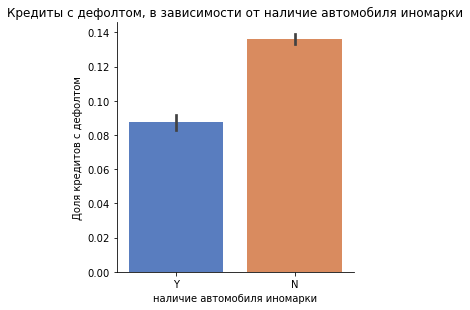

In [44]:
# среднее значение внутри каждой категории и отобразим ее доверительный интервал:
sns.catplot(x='car_type', y='default',  data=data,
            kind="bar", palette="muted", height=4)
plt.ylabel(u'Доля кредитов с дефолтом')
plt.xlabel(u'наличие автомобиля иномарки')
plt.title(u'Кредиты с дефолтом, в зависимости от наличие автомобиля иномарки')

In [45]:
tablecartype = pd.DataFrame({u'Без дефолта': data[data['default'] == 0].car_type.value_counts(
), u'С дефолтом': data[data['default'] == 1].car_type.value_counts()})
tablecartype

,Без дефолта,С дефолтом
N,51644,8147
Y,12783,1225


**car_type** - у 81.02% (59 791 человека) нет автомобиля иномарки. Из них 13.62% (8 147 из 59 791) имеют невозврат кредита. Есть автомобиль иномарка у 18.98% (14 008). Среди них невозвратов 8.75% (1 225 из 14 008). Разница в 4.87%. Поэтому признак car_type при построении модели можно считать значимым.

In [46]:
# Обозначаем значения Y как 1, остальные как ноль.
data['car_type'] = data['car_type'].apply(lambda x: 1 if x == 'Y' else 0)
df['car_type'] = df['car_type'].apply(lambda x: 1 if x == 'Y' else 0)

### foreign_passport — наличие загранпаспорта ('N'- нет, 'Y' да)

In [47]:
pd.DataFrame(data.foreign_passport.value_counts())

,foreign_passport
N,62733
Y,11066


In [48]:
# Посмотрим количество наличие загранпаспорта в процентах, так нагляднее
foreign_passport_ratio = round(pd.DataFrame(
    data.foreign_passport.value_counts()) / len(data)*100, 2)
print(foreign_passport_ratio)

   foreign_passport
N             85.01
Y             14.99


Text(0.5, 1.0, 'Кредиты с дефолтом, в зависимости от наличия загранпаспорта')

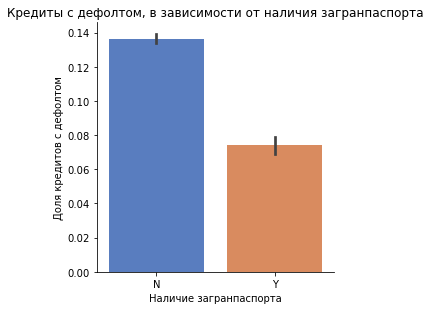

In [49]:
# среднее значение внутри каждой категории и отобразим ее доверительный интервал:
sns.catplot(x='foreign_passport', y='default',  data=data,
            kind="bar", palette="muted", height=4)
plt.ylabel(u'Доля кредитов с дефолтом')
plt.xlabel(u'Наличие загранпаспорта')
plt.title(u'Кредиты с дефолтом, в зависимости от наличия загранпаспорта')

In [50]:
tablepassport = pd.DataFrame({u'Без дефолта': data[data['default'] == 0].foreign_passport.value_counts(
), u'С дефолтом': data[data['default'] == 1].foreign_passport.value_counts()})
tablepassport

,Без дефолта,С дефолтом
N,54181,8552
Y,10246,820


**foreign_passport** - у 85.01% (62 733 человек) нет загранпаспорта. Из них 13.63% (8 552 из 62 733) имеют невозврат кредита. Есть загранпаспорт у 14.99% (11 066). Среди них невозвратов 7.41% (820 из 11 066). Разница в 6.22%. Поэтому признак foreign_passport при построении модели можно считать значимым.

In [51]:
# Обозначаем значения Y как 1, остальные как ноль.
data['foreign_passport'] = data['foreign_passport'].apply(
    lambda x: 1 if x == 'Y' else 0)
df['foreign_passport'] = df['foreign_passport'].apply(
    lambda x: 1 if x == 'Y' else 0)

### good_work — наличие «хорошей» работы ('0'- нет, '1' да)

In [52]:
pd.DataFrame(data.good_work.value_counts())

,good_work
0,61630
1,12169


In [53]:
# Посмотрим  в процентах, так нагляднее
good_work_ratio = round(pd.DataFrame(
    data.good_work.value_counts()) / len(data)*100, 2)
print(good_work_ratio)

   good_work
0      83.51
1      16.49


Text(0.5, 1.0, 'Кредиты с дефолтом, в зависимости от наличие «хорошей» работы')

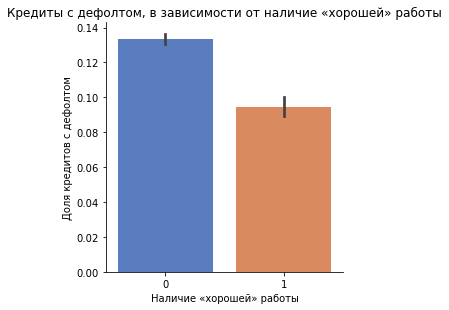

In [54]:
# среднее значение внутри каждой категории и отобразим ее доверительный интервал:
sns.catplot(x='good_work', y='default',  data=data,
            kind="bar", palette="muted", height=4)
plt.ylabel(u'Доля кредитов с дефолтом')
plt.xlabel(u'Наличие «хорошей» работы')
plt.title(u'Кредиты с дефолтом, в зависимости от наличие «хорошей» работы')

In [55]:
tablework = pd.DataFrame({u'Без дефолта': data[data['default'] == 0].good_work.value_counts(
), u'С дефолтом': data[data['default'] == 1].good_work.value_counts()})
tablework

,Без дефолта,С дефолтом
0,53408,8222
1,11019,1150


**good_work** - у 83.51% (61 630 человек) нет «хорошей» работы. Из них 13.34% (8 222 из 61 630) имеют невозврат кредита. Есть «хорошая» работа у 16.49% (12 169). Среди них невозвратов 9.45% (1 150 из 12 169). Разница в 3.89%. Признак good_work при построении модели можно считать значимым.

## Числовые переменные

- **age** - возраст заемщика
- **decline_app_cnt** - количество отказанных прошлых заявок
- **bki_request_cnt** - количество запросов в БКИ
- **income** - доход заемщика
- **score_bki** - скоринговый балл по данным из БКИ
- **days** - дней от подачи заявки

In [56]:
num_cols = ['age', 'decline_app_cnt', 'score_bki',
            'bki_request_cnt', 'income', 'days']

### age — возраст заёмщика

In [57]:
# pd.DataFrame(data.age.value_counts())

In [58]:
df.age.describe()

count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64

(array([ 9898., 13429., 11628., 10077.,  8327.,  6935.,  6383.,  4358.,
         2233.,   531.]),
 array([21. , 26.1, 31.2, 36.3, 41.4, 46.5, 51.6, 56.7, 61.8, 66.9, 72. ]),
 <BarContainer object of 10 artists>)

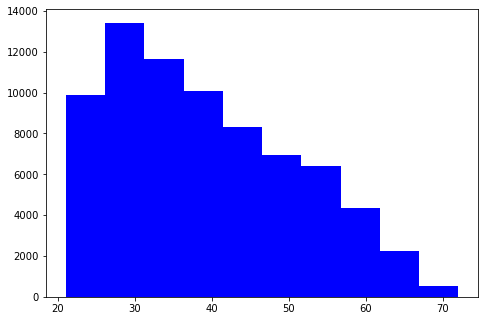

In [59]:
#  гистограмма распределения признака
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(data['age'], bins=10, color='blue')

In [60]:
# Выставим условное деление по категориям возраста
def mark_age(m):
    if m < 25:              # 21-25
        return 1
    if m >= 25 and m < 30:   # 25-29
        return 2
    if m >= 30 and m < 35:   # 30-34
        return 3
    if m >= 35 and m < 40:   # 35-39
        return 4
    if m >= 40 and m < 45:   # 40-44
        return 5
    if m >= 45 and m < 50:   # 45-49
        return 6
    if m >= 50 and m < 55:   # 50-54
        return 7
    if m >= 55 and m < 60:   # 55-59
        return 8
    if m >= 60 and m < 65:   # 60-64
        return 9
    if m >= 65:              # старше 65
        return 10


# добавим столбец по категориям возраста
data['age_mark'] = data.age.apply(mark_age)
df['age_mark'] = df.age.apply(mark_age)

Text(0.5, 1.0, 'Кредиты, в которых есть дефолт по возврату')

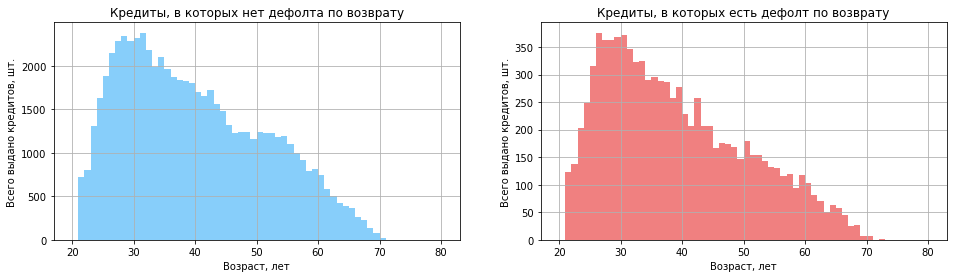

In [61]:
repayment = data[data.default == 0]
loan = data[data.default == 1]
pylab.figure(figsize(16, 4))
pylab.subplot(1, 2, 1)
repayment.age.hist(color='lightskyblue', bins=60, range=(20, 80))
pylab.xlabel(u'Возраст, лет')
pylab.ylabel(u'Всего выдано кредитов, шт.')
plt.title(u'Кредиты, в которых нет дефолта по возврату')
# pylab.legend()

pylab.subplot(1, 2, 2)
loan.age.hist(color='lightcoral', bins=60, range=(20, 80))
pylab.xlabel(u'Возраст, лет')
pylab.ylabel(u'Всего выдано кредитов, шт.')
plt.title(u'Кредиты, в которых есть дефолт по возврату')
# pylab.legend()

In [62]:
repayment = data[data.default == 0]
loan = data[data.default == 1]

Text(0.5, 1.0, 'Кредиты, в которых есть дефолт по возврату')

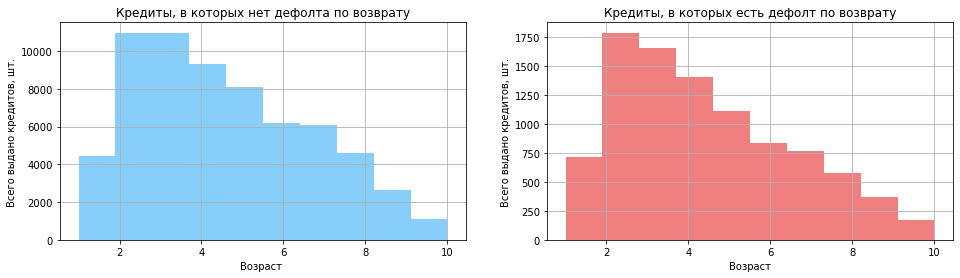

In [63]:
pylab.figure(figsize(16, 4))
pylab.subplot(1, 2, 1)
repayment.age_mark.hist(color='lightskyblue', bins=10, range=(1, 10))
pylab.xlabel(u'Возраст ')
pylab.ylabel(u'Всего выдано кредитов, шт.')
plt.title(u'Кредиты, в которых нет дефолта по возврату')

pylab.subplot(1, 2, 2)
loan.age_mark.hist(color='lightcoral', bins=10, range=(1, 10))
pylab.xlabel(u'Возраст')
pylab.ylabel(u'Всего выдано кредитов, шт.')
plt.title(u'Кредиты, в которых есть дефолт по возврату')

Text(0.5, 1.0, 'Кредиты с дефолтом, в зависимости от категории возраста')

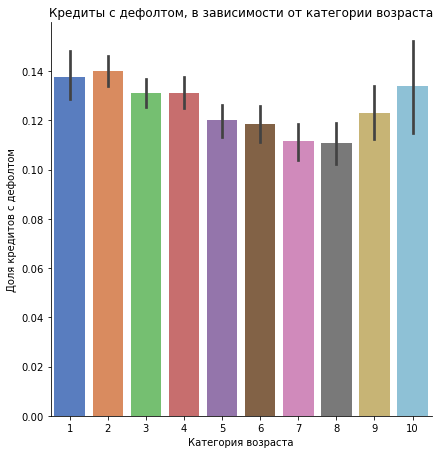

In [64]:
# среднее значение внутри каждой категории и отобразим ее доверительный интервал:
sns.catplot(x='age_mark', y='default',  data=data,
            kind="bar", palette="muted", height=6)
plt.ylabel(u'Доля кредитов с дефолтом')
plt.xlabel(u'Категория возраста')
plt.title(u'Кредиты с дефолтом, в зависимости от категории возраста')

  Самый большой процент невозвратов в возрасте 25-29 лет - 14.05%, самый маленький 55-59 лет 10.74%

- 1 21-25 лет 13,78%
- **2 25-29 лет 14,01%**
- 3 30-34 лет 13,10%
- 4 35-39 лет 13,12%
- 5 40-44 лет 11,99%
- 6 45-49 лет 11,84%
- 7 50-54 лет 11,14%
- **8 55-59 лет 11,08%**
- 9 60-64 лет 12,31%
- 10 старше 65 лет 13,39%

In [65]:
tableage = pd.DataFrame({u'Без дефолта': data[data['default'] == 0].age_mark.value_counts(
), u'С дефолтом': data[data['default'] == 1].age_mark.value_counts()})
tableage

,Без дефолта,С дефолтом
1,4456,712
2,10954,1785
3,10975,1655
4,9301,1405
5,8116,1106
6,6189,831
7,6085,763
8,4615,575
9,2643,371
10,1093,169


**age:** Возраст заемщиков от 21 до 72 лет. Средний возраст 39 лет. Чаще всего кредиты берут в возрасте 26-31 лет. Самый большой процент невозвратов в возрасте 25-29 лет - 14.01%, самый маленький 55-59 лет 11.08%. Добавлен новый признак age_mark с разбивкой по категориям возраста. Считать ли выбросами возраст старше 65 лет не знаю. Вероятно в свете последних тенденций нет.

### income — доход заёмщика

In [66]:
df.income.describe()

count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

(array([1.09095e+05, 8.27000e+02, 1.49000e+02, 3.90000e+01, 3.80000e+01]),
 array([   1000.,  200800.,  400600.,  600400.,  800200., 1000000.]),
 <BarContainer object of 5 artists>)

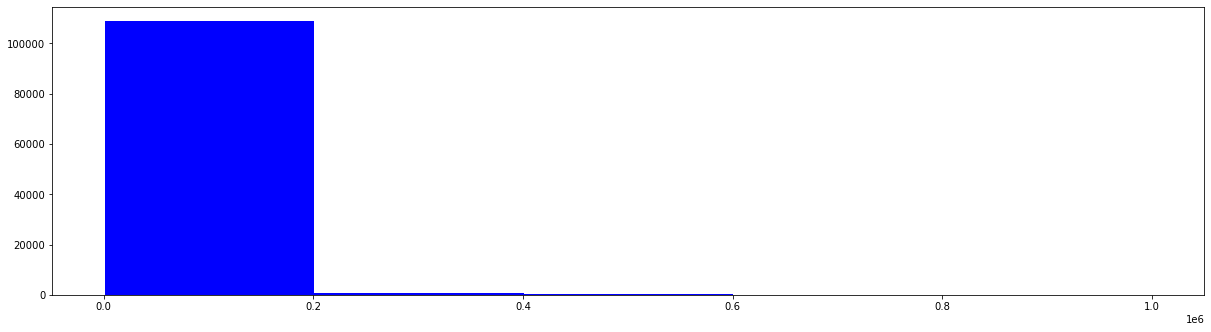

In [67]:
#  гистограмма распределения признака
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(df['income'], bins=5, color='blue')

In [68]:
income_max_df = df[df.income == 1000000]
income_max = data[data.income == 1000000]
len(income_max)

10

In [69]:
income_max.head(15)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,age_mark
1279,106055,25APR2014,PGR,1,38,1,1,0,0,-1.352636,1,60,2,3,1000000,2,2,0,0,1,4
4150,92995,09APR2014,SCH,1,47,1,1,0,0,-2.401704,0,40,2,3,1000000,2,2,0,0,1,6
9479,14016,21JAN2014,GRD,1,65,0,0,0,0,-2.569665,3,40,1,3,1000000,1,4,1,0,1,10
14799,69023,17MAR2014,GRD,1,43,1,1,0,0,-2.555922,0,80,2,3,1000000,1,4,1,0,1,5
15640,93677,10APR2014,GRD,1,34,1,1,0,1,-3.029282,3,50,2,3,1000000,1,2,1,0,1,3
26424,27158,03FEB2014,NaN,1,41,1,1,0,1,-1.328527,8,50,1,2,1000000,1,4,1,0,1,5
35533,84992,01APR2014,GRD,1,47,0,0,0,0,-1.923850,1,50,2,3,1000000,2,3,0,0,1,6
37810,42089,18FEB2014,GRD,1,53,1,1,0,0,-2.881532,1,50,1,1,1000000,1,3,1,0,1,7
39728,61380,11MAR2014,GRD,1,43,1,1,0,0,-2.061585,3,50,1,3,1000000,1,3,1,0,1,5
42271,97529,14APR2014,SCH,0,56,0,0,0,0,-1.639887,0,60,1,2,1000000,1,3,1,0,1,8


С максимальным доходом в 1000000 в наборе данных 13 человек.  В трейне 10 человек. Наличие дефолта у всех 0. Это 9 мужчин и 1 женщина 56 лет.  Возраст 34,38,41,43,43,47,47,56,65 лет. С образованием SCH (2), GRD (6), PGR (1), OTHER(1). Два человека имеют "хорошую" работу. Загранпаспортов нет у 3 человек. Категория домашнего адреса 1 или 2. Категория рабочего адреса разная. Не имеют отказанных прошлых заявок. 2 человека не имеют запросов в БКИ. Автомобилей нет у 3 человек. У остальных иномарки.

In [70]:
income_min = data[data.income == 1000]
income_min_df = df[df.income == 1000]
len(income_min_df)

6

In [71]:
income_min.head(7)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,age_mark
28038,93032,09APR2014,UGR,0,25,0,0,0,0,-2.035382,3,50,1,1,1000,4,3,0,0,1,2
32795,78926,27MAR2014,SCH,0,28,1,0,0,1,-2.547642,0,50,1,2,1000,1,4,0,0,1,2
42595,50161,27FEB2014,SCH,0,44,0,0,0,0,-1.470504,2,60,2,3,1000,4,1,0,0,1,5
58099,49967,26FEB2014,SCH,0,25,0,0,0,0,-2.024100,1,50,1,2,1000,1,3,0,0,1,2
66425,90457,07APR2014,UGR,0,58,0,0,1,0,-0.804162,6,60,2,3,1000,4,1,0,0,1,8


С минимальным доходом в 1000 в наборе данных 6 человек. В трейне 5 человек. Наличие дефолта у всех 0. Это женщины  с возрастом 25, 25, 28, 44, 58 лет. С образованием SCH или UGR. Один человек 28 лет имеет "хорошую" работу с категорией рабочего адреса 2, не имеет запросов в БКИ, имеет отечественный автомобиль. Загранпаспортов нет. Категория домашнего адреса 1 или 2. Категория рабочего адреса разная. Клиент 58 лет имеет 1 отказанную прошлую заявку и 6 запросов в БКИ.

In [72]:
repayment = data[data.default == 0]
loan = data[data.default == 1]

Text(0.5, 1.0, 'Кредиты, в которых есть просрочки по возврату')

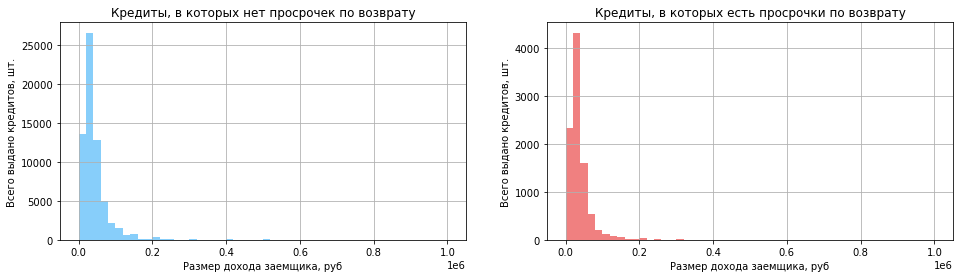

In [73]:
pylab.figure(figsize(16, 4))
pylab.subplot(1, 2, 1)
repayment.income.hist(color='lightskyblue', bins=50, range=(0, 1000000))
pylab.xlabel(u'Размер дохода заемщика, руб')
pylab.ylabel(u'Всего выдано кредитов, шт.')
plt.title(u'Кредиты, в которых нет просрочек по возврату')
# pylab.legend()

pylab.subplot(1, 2, 2)
loan.income.hist(color='lightcoral', bins=50, range=(0, 1000000))
pylab.xlabel(u'Размер дохода заемщика, руб')
pylab.ylabel(u'Всего выдано кредитов, шт.')
plt.title(u'Кредиты, в которых есть просрочки по возврату')

In [74]:
# надо переделать под decribe
def mark_income(m):
    if m == 1000:               # минимум
        return 1
    if m > 1000 and m <= 20000:
        return 2
    if m > 20000 and m <= 30000:
        return 3
    if m > 30000 and m <= 48000:
        return 4
    if m > 48000 and m <= 100000:
        return 5
    if m > 100000 and m < 200000:
        return 6
    if m >= 200000 and m < 400000:
        return 7
    if m >= 400000:
        return 8


# добавим столбец
data['income_mark'] = data.income.apply(mark_income)
df['income_mark'] = df.income.apply(mark_income)

In [75]:
pd.DataFrame(data.income_mark.value_counts())

,income_mark
2,21425
3,18719
4,15372
5,15139
6,2085
7,849
8,205
1,5


In [76]:
repayment = data[data.default == 0]
loan = data[data.default == 1]

Text(0.5, 1.0, 'Кредиты, в которых есть просрочки по возврату')

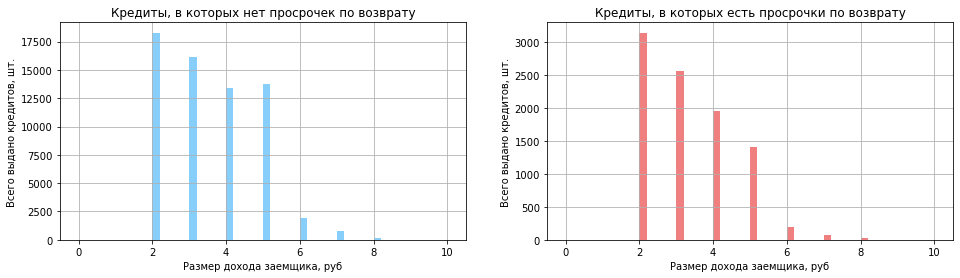

In [77]:
pylab.figure(figsize(16, 4))
pylab.subplot(1, 2, 1)
repayment.income_mark.hist(color='lightskyblue', bins=50, range=(0, 10))
pylab.xlabel(u'Размер дохода заемщика, руб')
pylab.ylabel(u'Всего выдано кредитов, шт.')
plt.title(u'Кредиты, в которых нет просрочек по возврату')
# pylab.legend()

pylab.subplot(1, 2, 2)
loan.income_mark.hist(color='lightcoral', bins=50, range=(0, 10))
pylab.xlabel(u'Размер дохода заемщика, руб')
pylab.ylabel(u'Всего выдано кредитов, шт.')
plt.title(u'Кредиты, в которых есть просрочки по возврату')

<AxesSubplot:>

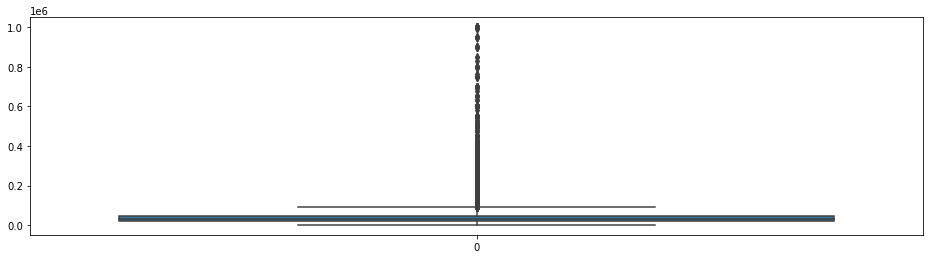

In [78]:
sns.boxplot(data=df.income)

**income** - доходы клиентов от 1000 до 1000000. 50% клиентов имеет доход  в районе 30000. Большой диапазон. Но выбросами не решаюсь это назвать, в информации по клиентам ничего необычного. Минимальный и максимальный доход вероятно имеет право быть.

### bki_request_cnt — количество запросов в БКИ

In [79]:
df.bki_request_cnt.describe()

count    110148.000000
mean          2.005002
std           2.266926
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: bki_request_cnt, dtype: float64

(array([1.09056e+05, 1.02300e+03, 5.40000e+01, 1.10000e+01, 4.00000e+00]),
 array([ 0. , 10.6, 21.2, 31.8, 42.4, 53. ]),
 <BarContainer object of 5 artists>)

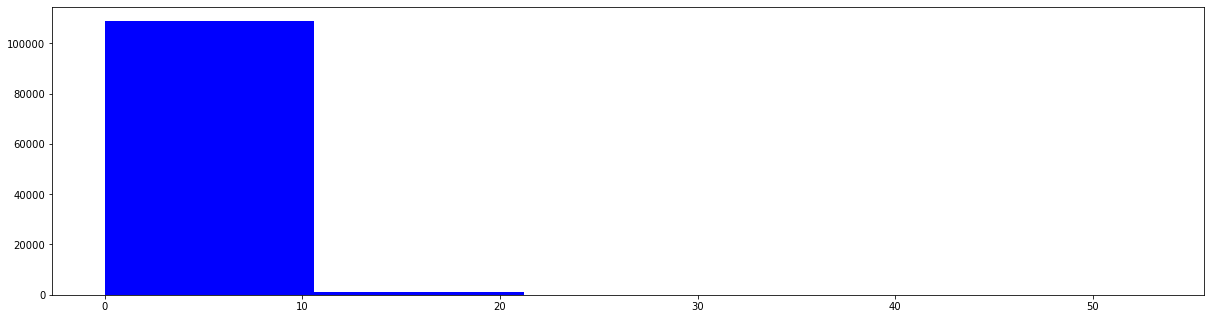

In [80]:
#  гистограмма распределения признака
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(df['bki_request_cnt'], bins=5, color='blue')

In [81]:
# pd.DataFrame(df.bki_request_cnt.value_counts())

In [82]:
repayment = data[data.default == 0]
loan = data[data.default == 1]

Text(0.5, 1.0, 'Кредиты, в которых есть дефолты по возврату')

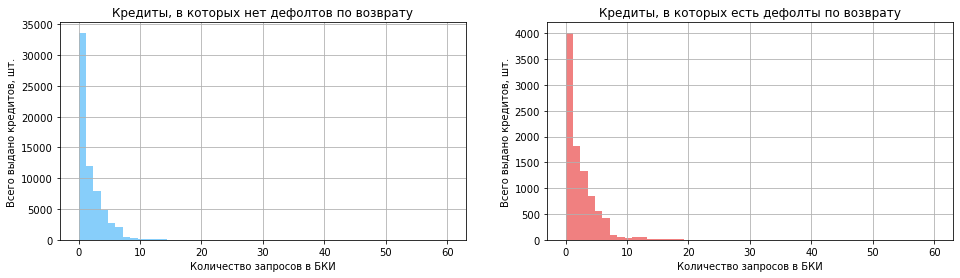

In [83]:
pylab.figure(figsize(16, 4))
pylab.subplot(1, 2, 1)
repayment.bki_request_cnt.hist(color='lightskyblue', bins=50, range=(0, 60))
pylab.xlabel(u'Количество запросов в БКИ')
pylab.ylabel(u'Всего выдано кредитов, шт.')
plt.title(u'Кредиты, в которых нет дефолтов по возврату')
# pylab.legend()

pylab.subplot(1, 2, 2)
loan.bki_request_cnt.hist(color='lightcoral', bins=50, range=(0, 60))
pylab.xlabel(u'Количество запросов в БКИ')
pylab.ylabel(u'Всего выдано кредитов, шт.')
plt.title(u'Кредиты, в которых есть дефолты по возврату')

<AxesSubplot:>

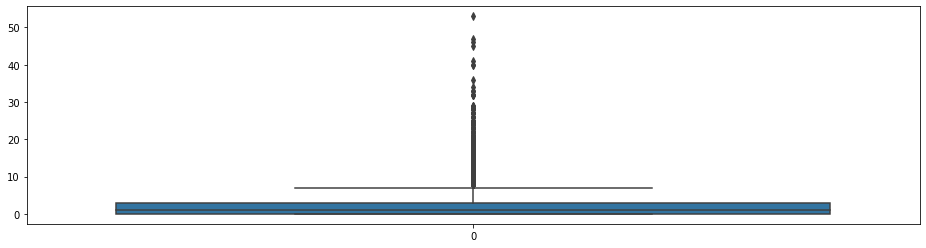

In [84]:
# построим ящик с усами чтобы проверить на наличие выбросов
sns.boxplot(data=df.bki_request_cnt)

**bki_request_cnt**  - 26.2% клиентов не делали запросов в БКИ

### decline_app_cnt — количество отказанных прошлых заявок

In [85]:
df.decline_app_cnt.describe()

count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64

(array([7.3674e+04, 1.1600e+02, 6.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([ 0. ,  6.6, 13.2, 19.8, 26.4, 33. ]),
 <BarContainer object of 5 artists>)

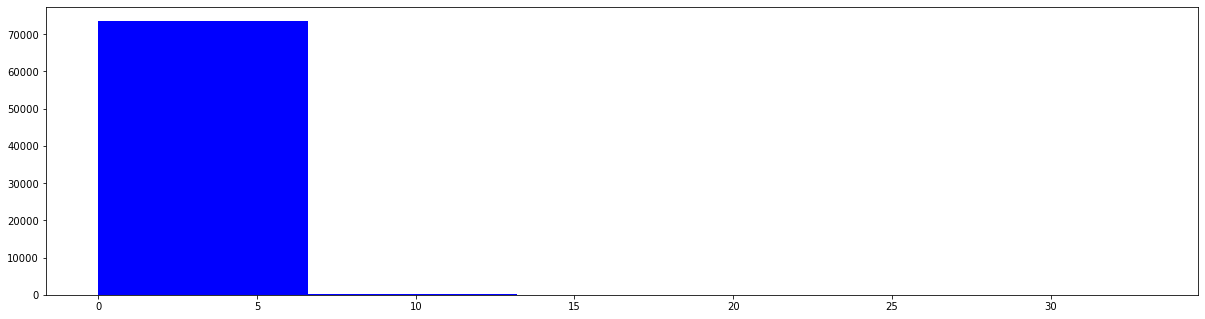

In [86]:
#  гистограмма распределения признака
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(data['decline_app_cnt'], bins=5, color='blue')

In [87]:
repayment = data[data.default == 0]
loan = data[data.default == 1]

Text(0.5, 1.0, 'Кредиты, в которых есть дефолты по возврату')

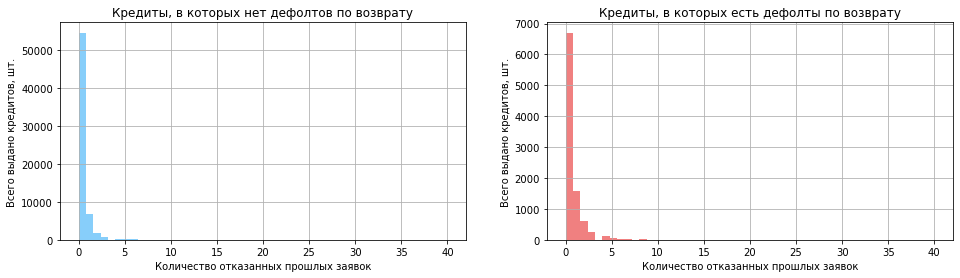

In [88]:
pylab.figure(figsize(16, 4))
pylab.subplot(1, 2, 1)
repayment.decline_app_cnt.hist(color='lightskyblue', bins=50, range=(0, 40))
pylab.xlabel(u'Количество отказанных прошлых заявок')
pylab.ylabel(u'Всего выдано кредитов, шт.')
plt.title(u'Кредиты, в которых нет дефолтов по возврату')
# pylab.legend()

pylab.subplot(1, 2, 2)
loan.decline_app_cnt.hist(color='lightcoral', bins=50, range=(0, 40))
pylab.xlabel(u'Количество отказанных прошлых заявок')
pylab.ylabel(u'Всего выдано кредитов, шт.')
plt.title(u'Кредиты, в которых есть дефолты по возврату')
# pylab.legend()

<AxesSubplot:>

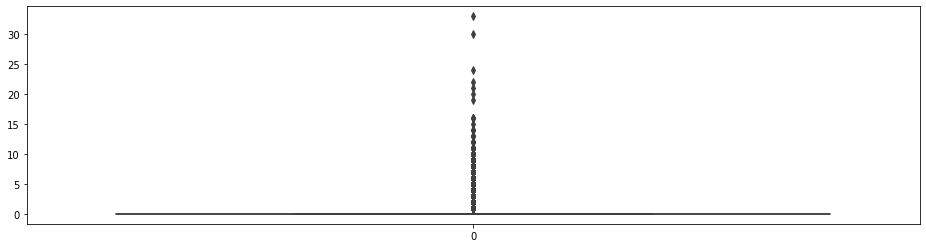

In [89]:
# построим ящик с усами чтобы проверить на наличие выбросов
sns.boxplot(data=df.decline_app_cnt)

**decline_app_cnt** — количество отказанных прошлых заявок от 0 до 33. Выбросы есть, но может быть это и нормально иметь столько отказанных прошлых заявок.

## score_bki - скоринговый балл по данным из БКИ

In [90]:
df.score_bki.describe()

count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64

In [91]:
repayment = data[data.default == 0]
loan = data[data.default == 1]

Text(0.5, 1.0, 'Кредиты, в которых есть дефолты по возврату')

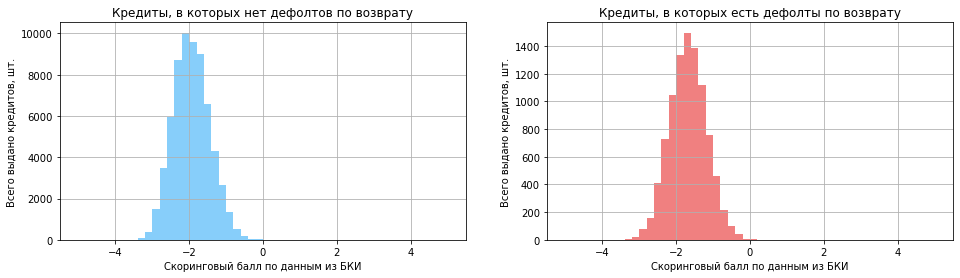

In [92]:
pylab.figure(figsize(16, 4))
pylab.subplot(1, 2, 1)
repayment.score_bki.hist(color='lightskyblue', bins=50, range=(-5, 5))
pylab.xlabel(u'Скоринговый балл по данным из БКИ')
pylab.ylabel(u'Всего выдано кредитов, шт.')
plt.title(u'Кредиты, в которых нет дефолтов по возврату')
# pylab.legend()

pylab.subplot(1, 2, 2)
loan.score_bki.hist(color='lightcoral', bins=50, range=(-5, 5))
pylab.xlabel(u'Скоринговый балл по данным из БКИ')
pylab.ylabel(u'Всего выдано кредитов, шт.')
plt.title(u'Кредиты, в которых есть дефолты по возврату')
# pylab.legend()

In [93]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,age_mark,income_mark
0,74835,22MAR2014,GRD,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,0,0,2,5
1,17527,24JAN2014,SCH,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,0,0,4,2
2,75683,23MAR2014,UGR,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,0,0,7,3
3,26883,03FEB2014,SCH,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,0,0,8,2
4,28862,04FEB2014,GRD,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,0,0,4,6


In [94]:
m = df.score_bki.min()
df['score_bki'] = df['score_bki'] - m + 1
m = data.score_bki.min()
data['score_bki'] = data['score_bki'] - m + 1
m = df.score_bki.min()
m

1.0

In [95]:
m = data.score_bki.min()
m

1.0

In [96]:
df.score_bki.max()

4.82435917

<AxesSubplot:>

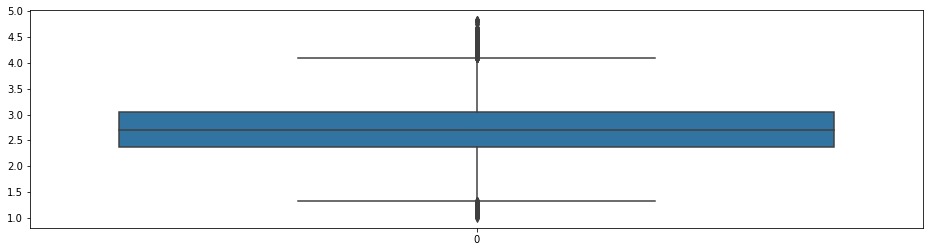

In [97]:
# построим ящик с усами чтобы проверить на наличие выбросов
sns.boxplot(data=df.score_bki)

In [98]:
df.score_bki.describe()

count    110148.000000
mean          2.720051
std           0.499397
min           1.000000
25%           2.364153
50%           2.703763
75%           3.056698
max           4.824359
Name: score_bki, dtype: float64

**score_bki** - похоже, что скоринговый балл по данным из БКИ чем меньше, тем лучше. Избавляемся от отрицательных значений прибавлением минимального знчения плюс 1. Было от -3.624586 до 0.199773. Стало от 1 до 4.82435917.

## app_date - дата подачи заявки

In [99]:
# Взглянем поближе на признак app_date
data.app_date.head(5)

0    01FEB2014
1    12MAR2014
2    01FEB2014
3    23JAN2014
4    18APR2014
Name: app_date, dtype: object

In [100]:
# посмотрим на частоту встречаемости дат
s = pd.DataFrame(df.app_date.value_counts())
s.head(20)

,app_date
18MAR2014,1491
19MAR2014,1363
17MAR2014,1350
31MAR2014,1317
07APR2014,1296
02APR2014,1291
11MAR2014,1245
04MAR2014,1242
01APR2014,1239
11FEB2014,1233


In [101]:
# сколько всего дат
len(s)

120

In [102]:
#Создадим список из самых частых дат
lst = list(df['app_date'].value_counts().index[:11]) 
#Расставим флаг с помощью лямбда-функции и проверим результат
df['freg_data'] = df['app_date'].apply(lambda x: 1 if x in lst else 0) 
df['freg_data'].value_counts()

0    95855
1    14293
Name: freg_data, dtype: int64

In [103]:
data['freg_data'] = data['app_date'].apply(lambda x: 1 if x in lst else 0) 
data['freg_data'].value_counts()

0    64153
1     9646
Name: freg_data, dtype: int64

In [104]:
import datetime
from datetime import datetime, date
# Конвертируем в более удобный формат даты
data.app_date = pd.to_datetime(data.app_date)
df.app_date = pd.to_datetime(df.app_date)
print(data.app_date.head(5))

0   2014-02-01
1   2014-03-12
2   2014-02-01
3   2014-01-23
4   2014-04-18
Name: app_date, dtype: datetime64[ns]


In [105]:
# по дням недели
df['week_day'] = df['app_date'].apply(lambda x: datetime.weekday(x))
data['week_day'] = data['app_date'].apply(lambda x: datetime.weekday(x))

In [106]:
# На основе признака app_date делаем новый признак
current_date = pd.to_datetime('27JAN2021')
# Количество дней, прошедших со дня подачи заявки
data['days'] = (current_date - data.app_date).dt.days
data['month'] = data['app_date'].dt.month
# Количество дней, прошедших со дня подачи заявки
df['days'] = (current_date - df.app_date).dt.days
df['month'] = df['app_date'].dt.month
m = df['days'].min()
df['days'] = df['days'] - m + 1
data['days'] = data['days'] - m + 1

In [107]:
m = df['days'].min()
m

1

In [108]:
m = data['days'].min()
m

1

## Категориальные переменные

- **education** - уровень образования
- **home_address** - категоризатор домашнего адреса
- **work_address** - категоризатор рабочего адреса
- **sna** - связь заемщика с клиентами банка
- **first_time** - давность наличия информации о заемщике
- **region_rating** - рейтинг региона

In [109]:
cat_cols = ['education', 'home_address', 'work_address',
            'sna', 'first_time', 'region_rating']

### education — уровень образования

Признак имеет пропуски. Посмотрим на эти записи.

In [110]:
education_null = df[df.education.isnull()]
education_null.describe()

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,age_mark,income_mark,freg_data,week_day,days,month
count,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000
mean,50891.301255,0.456067,41.437238,0.418410,0.161088,0.106695,0.142259,2.678952,1.761506,60.418410,1.619247,2.562762,46240.956067,1.635983,2.905858,0.173640,0.642259,0.073222,4.878661,3.546025,0.133891,2.600418,63.267782,2.403766
std,29896.364365,0.498588,11.317749,0.493815,0.367997,0.392697,0.349682,0.488655,2.136246,14.830723,0.511304,0.659739,66930.420691,1.114664,1.052862,0.379197,0.479837,0.260773,2.273243,1.332144,0.340892,1.973982,30.082546,1.031042
min,1077.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,1.081181,0.000000,30.000000,1.000000,1.000000,5000.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000
25%,26489.750000,0.000000,33.000000,0.000000,0.000000,0.000000,0.000000,2.350267,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,2.000000,0.000000,1.000000,40.000000,2.000000
50%,49040.500000,0.000000,41.000000,0.000000,0.000000,0.000000,0.000000,2.655898,1.000000,60.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000,1.000000,0.000000,5.000000,3.000000,0.000000,2.000000,64.500000,2.000000
75%,74787.750000,1.000000,49.750000,1.000000,0.000000,0.000000,0.000000,2.985175,2.000000,80.000000,2.000000,3.000000,50000.000000,2.000000,4.000000,0.000000,1.000000,0.000000,6.750000,5.000000,0.000000,4.000000,87.750000,3.000000
max,109503.000000,1.000000,72.000000,1.000000,1.000000,3.000000,1.000000,4.170158,15.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000,1.000000,10.000000,8.000000,1.000000,6.000000,116.000000,4.000000


Определить образование не передставляется возможным. 

In [111]:
# пока пропуски заполняем 'OTHER'
data['education'].fillna('OTHER', inplace=True)
df['education'].fillna('OTHER', inplace=True)

In [112]:
# Создаем новый признак. Обозначаю значения с пропусками как 1, остальные как ноль.
data['education_null'] = data['education'].apply(
    lambda x: 1 if x == 'OTHER' else 0)
df['education_null'] = df['education'].apply(
    lambda x: 1 if x == 'OTHER' else 0)

In [113]:
pd.DataFrame(data.education.value_counts())

,education
SCH,38860
GRD,23365
UGR,9816
PGR,1257
OTHER,307
ACD,194


In [114]:
# Посмотрим количество в процентах, так нагляднее
education_ratio = round(pd.DataFrame(
    df.education.value_counts()) / len(df)*100, 2)
print(education_ratio)

       education
SCH        52.65
GRD        31.56
UGR        13.39
PGR         1.69
OTHER       0.43
ACD         0.26


Посмотрим, как зависит наличие просрочек от типа образования:

Text(0.5, 1.0, 'Кредиты с просрочками, в зависимости от образования')

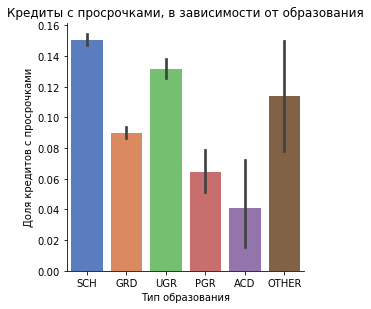

In [115]:
# среднее значение внутри каждой категории и отобразим ее доверительный интервал:
sns.catplot(x='education', y='default',  data=data,
            kind="bar", palette="muted", height=4)
plt.ylabel(u'Доля кредитов с просрочками')
plt.xlabel(u'Тип образования')
plt.title(u'Кредиты с просрочками, в зависимости от образования')

У клиентов имеющих образование ACD и PGR небольшой процент невозрата. Значительный высокий процент у имеющих образование SCH и UGR. Поэтому необходимо считать признак EDUCATION как важным при построении модели.

Составим таблицу сопряженности для образования и возврата / не возврата кредита:

In [116]:
tableEducation = pd.DataFrame({u'Без дефолта': data[data['default'] == 0].education.value_counts(
), u'С дефолтом': data[data['default'] == 1].education.value_counts()})
tableEducation

,Без дефолта,С дефолтом
SCH,33008,5852
GRD,21260,2105
UGR,8525,1291
PGR,1176,81
OTHER,272,35
ACD,186,8


Доля невозврата для имеющих образование SCH	0.1773,  UGR 0.1514, OTHER 0.1287, GRD 0.099, PGR 0.0689, ACD 0.043

**education**  Признак имел в трейне пропуски (0.43%), которые заменены на признак OTHER. Больше всего клиентов с образованием SCH 52.66% (38 860) имеют невозвратов 17.73% (5 852 из 38 860). Меньше всего клиентов с образованием ACD 0.26% (194)  имеют невозвратов 4.43% (8 из 194) . Гипотеза о независимости образования и наличия/отсутствия просрочек в оплате кредита отвергается. Признак education является важным при рассмотрении заявки на кредит.

In [117]:
# заменим текстовые значения на числовые
data["education"].value_counts()

SCH      38860
GRD      23365
UGR       9816
PGR       1257
OTHER      307
ACD        194
Name: education, dtype: int64

In [118]:
label_encoder = LabelEncoder()
mapped_education = pd.Series(label_encoder.fit_transform(data['education']))
data['education'] = label_encoder.fit_transform(data['education'])
data["education"].value_counts()

4    38860
1    23365
5     9816
3     1257
2      307
0      194
Name: education, dtype: int64

In [119]:
label_encoder = LabelEncoder()
mapped_education = pd.Series(label_encoder.fit_transform(df['education']))
df['education'] = label_encoder.fit_transform(df['education'])
df['education'].value_counts()

4    57998
1    34768
5    14748
3     1865
2      478
0      291
Name: education, dtype: int64

## home_address — категоризатор домашнего адреса

In [120]:
pd.DataFrame(df.home_address.value_counts())

,home_address
2,59591
1,48688
3,1869


In [121]:
pd.DataFrame(data.home_address.value_counts())

,home_address
2,39956
1,32585
3,1258


In [122]:
# Посмотрим количество в процентах, так нагляднее
home_address_ratio = round(pd.DataFrame(
    data.home_address.value_counts()) / len(data)*100, 2)
print(home_address_ratio)

   home_address
2         54.14
1         44.15
3          1.70


In [123]:
data.groupby(['good_work', 'home_address']).income.mean()

good_work  home_address
0          1               39235.473643
           2               41769.188847
           3               40634.006744
1          1               37801.562707
           2               48130.403010
           3               45028.868182
Name: income, dtype: float64

Text(0.5, 1.0, 'Кредиты с просрочками, в зависимости от категории домашнего адреса')

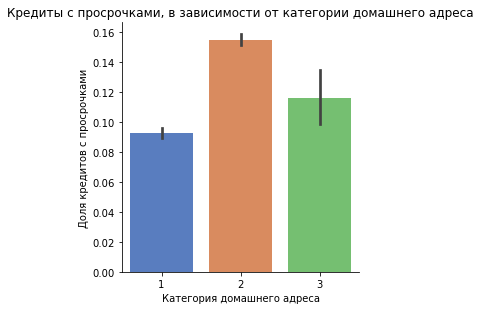

In [124]:
# среднее значение внутри каждой категории и отобразим ее доверительный интервал:
sns.catplot(x='home_address', y='default',  data=data,
            kind="bar", palette="muted", height=4)
plt.ylabel(u'Доля кредитов с просрочками')
plt.xlabel(u'Категория домашнего адреса')
plt.title(u'Кредиты с просрочками, в зависимости от категории домашнего адреса')

In [125]:
tablehome = pd.DataFrame({u'Без просрочек': data[data['default'] == 0].home_address.value_counts(
), u'С просрочками': data[data['default'] == 1].home_address.value_counts()})
tablehome

,Без просрочек,С просрочками
2,33757,6199
1,29558,3027
3,1112,146


**home_address** Больше всего клиентов с 2 категорией домашнего адреса 54.14 (39 956) имеют невозвратов 15.51% (6 199 из 39 956). Меньше всего клиентов с 3 категорией домашнего адреса 1.70% (1 258) имеют невозвратов 11.6% (146 из 1 258). Клиентов с 1 категорией 44.15% (32 585), они имеют невозвратов 9.29% (3 027 из 32 585). Таким образом внутри категории имеем разный процент невозврата от 9.29 до 15.51. Признак home_address является важным при рассмотрении заявки на кредит.

## work_address — категоризатор рабочего адреса

In [126]:
pd.DataFrame(df.work_address.value_counts())

,work_address
3,67113
2,30761
1,12274


In [127]:
pd.DataFrame(data.work_address.value_counts())

,work_address
3,44959
2,20506
1,8334


In [128]:
# Посмотрим количество в процентах, так нагляднее
work_address_ratio = round(pd.DataFrame(
    data.work_address.value_counts()) / len(data)*100, 2)
print(work_address_ratio)

   work_address
3         60.92
2         27.79
1         11.29


Text(0.5, 1.0, 'Кредиты с просрочками, в зависимости от категории рабочего адреса')

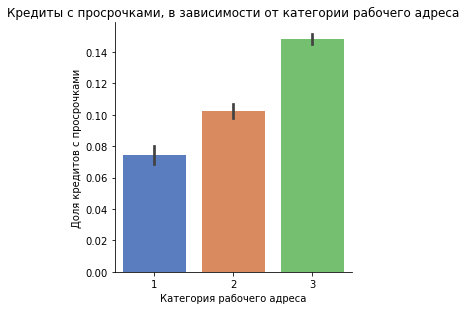

In [129]:
# среднее значение внутри каждой категории и отобразим ее доверительный интервал:
sns.catplot(x='work_address', y='default',  data=data,
            kind="bar", palette="muted", height=4)
plt.ylabel(u'Доля кредитов с просрочками')
plt.xlabel(u'Категория рабочего адреса')
plt.title(u'Кредиты с просрочками, в зависимости от категории рабочего адреса')

In [130]:
tablework = pd.DataFrame({u'Без дефолта': data[data['default'] == 0].work_address.value_counts(
), u'С дефолтом': data[data['default'] == 1].work_address.value_counts()})
tablework

,Без дефолта,С дефолтом
3,38307,6652
2,18404,2102
1,7716,618


**work_address** Больше всего клиентов с 2 категорией рабочего адреса 60.92% (44 959) имеют невозвратов 14.8% (6 652 из 44 959). Меньше всего клиентов с 1 категорией домашнего адреса 11.29% (8 334) имеют невозвратов 7.42% (618 из 8 334). Клиентов с 2 категорией 27.79% (20 506), они имеют невозвратов 10.25% (2 102 из 20 506). Таким образом внутри категории имеем разный процент невозврата от 9.29 до 15.51. Признак work_address является важным при рассмотрении заявки на кредит.

## region_rating - рейтинг региона

In [131]:
pd.DataFrame(df.region_rating.value_counts())

,region_rating
50,40981
60,23999
40,17947
80,17170
70,9304
30,434
20,313


In [132]:
pd.DataFrame(data.region_rating.value_counts())

,region_rating
50,27523
60,16075
40,12027
80,11469
70,6199
30,300
20,206


In [133]:
# Посмотрим количество в процентах, так нагляднее
region_rating_ratio = round(pd.DataFrame(
    data.region_rating.value_counts()) / len(data)*100, 2)
print(region_rating_ratio)

    region_rating
50          37.29
60          21.78
40          16.30
80          15.54
70           8.40
30           0.41
20           0.28


Text(0.5, 1.0, 'Кредиты с просрочками, в зависимости от рейтинга региона')

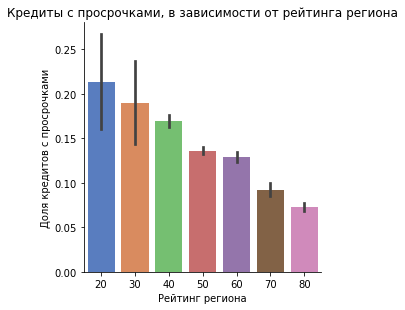

In [134]:
# среднее значение внутри каждой категории и отобразим ее доверительный интервал:
sns.catplot(x='region_rating', y='default',  data=data,
            kind="bar", palette="muted", height=4)
plt.ylabel(u'Доля кредитов с просрочками')
plt.xlabel(u'Рейтинг региона')
plt.title(u'Кредиты с просрочками, в зависимости от рейтинга региона')

**region_rating** Больше всего клиентов с рейтингом региона 50- 37.29%. Невозвратов кредитов больше всего у региона с рейтингом 20. Меньше всего клиентов у региона с рейтингом 20 - 0.28%. Невозвратов кредитов меньше  всего у региона с рейтингом 80.

## sna - связь заемщика с клиентами банка

In [135]:
pd.DataFrame(df.sna.value_counts())

,sna
1,70681
4,17481
2,15832
3,6154


In [136]:
pd.DataFrame(data.sna.value_counts())

,sna
1,47301
4,11749
2,10626
3,4123


In [137]:
# Посмотрим количество в процентах, так нагляднее
sna_ratio = round(pd.DataFrame(data.sna.value_counts()) / len(data)*100, 2)
print(sna_ratio)

     sna
1  64.09
4  15.92
2  14.40
3   5.59


Text(0.5, 1.0, 'Кредиты с просрочками, в зависимости cвязи заемщика с клиентами банка')

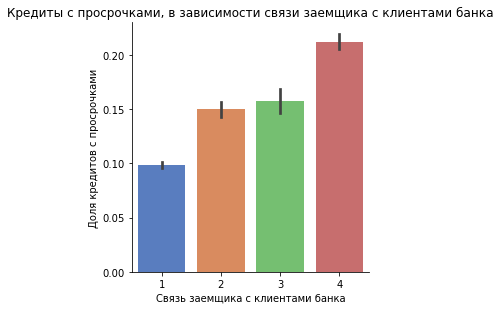

In [138]:
# среднее значение внутри каждой категории и отобразим ее доверительный интервал:
sns.catplot(x='sna', y='default',  data=data,
            kind="bar", palette="muted", height=4)
plt.ylabel(u'Доля кредитов с просрочками')
plt.xlabel(u'Cвязь заемщика с клиентами банка')
plt.title(u'Кредиты с просрочками, в зависимости cвязи заемщика с клиентами банка')

**sna** - хуже всех с возвратом у клиентов с типом связи заемщика с клиентами банка 4. Лучше всех с типом связи 1, хотя клиентов с этип типом больше всех 64.09% 

## first_time - давность наличия информации о заемщике

In [139]:
pd.DataFrame(df.first_time.value_counts())

,first_time
3,46588
4,28017
1,18296
2,17247


In [140]:
pd.DataFrame(data.first_time.value_counts())

,first_time
3,31255
4,18737
1,12239
2,11568


In [141]:
# Посмотрим количество в процентах, так нагляднее
first_time_ratio = round(pd.DataFrame(
    data.first_time.value_counts()) / len(data)*100, 2)
print(first_time_ratio)

   first_time
3       42.35
4       25.39
1       16.58
2       15.68


Text(0.5, 1.0, 'Кредиты с просрочками, в зависимости давностью наличия информации о заемщике')

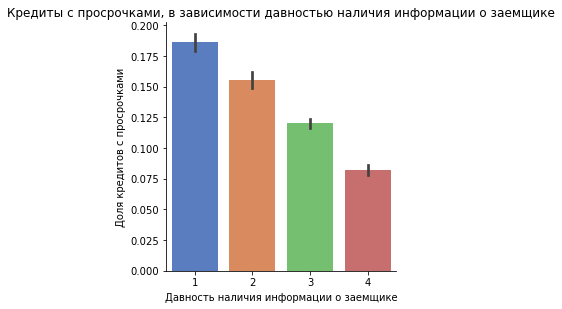

In [142]:
# среднее значение внутри каждой категории и отобразим ее доверительный интервал:
sns.catplot(x='first_time', y='default',  data=data,
            kind="bar", palette="muted", height=4)
plt.ylabel(u'Доля кредитов с просрочками')
plt.xlabel(u'Давность наличия информации о заемщике')
plt.title(
    u'Кредиты с просрочками, в зависимости давностью наличия информации о заемщике')

**first_time** - невозвратов больше всех у клиентов с типом давности наличия информации о заемщике 1. Клиентов больше всего с типом 3 - 42.35%.

**Преобразования и новые признаки**

In [143]:
data['region_rating'] = data['region_rating'] / 10
data['age'] = data['age']/10
data['decline_app_cnt'] = (data['decline_app_cnt']+1) / 10
data['decline_app_cnt'] = (data['bki_request_cnt']+1) / 10
data['income'] = round(data['income'] / 100000, 4)

In [144]:
df['region_rating'] = df['region_rating'] / 10
df['age'] = df['age']/10
df['decline_app_cnt'] = (df['decline_app_cnt'] + 1) / 10
df['decline_app_cnt'] = (df['bki_request_cnt'] + 1) / 10
df['income'] = round(df['income'] / 100000, 4)

In [145]:
# создаем новый признак   0.187099
data['score_region'] = (
    data['score_bki'] * data['first_time'] * data['region_rating']) / 100
# заменяем бесконечные значения на 0
data['score_region'].replace([np.inf, -np.inf], 0, inplace=True)
# создаем новый признак   df
df['score_region'] = (df['score_bki'] * df['first_time']
                      * df['region_rating']) / 100
# заменяем бесконечные значения на 0
df['score_region'].replace([np.inf, -np.inf], 0, inplace=True)

# создаем новый признак   0.175357
data['bki_income'] = (11 + data['score_bki'] -
                      (3 + data['car'] + data['good_work'] +
                       data['foreign_passport']) / 3 - data['income'] + data['decline_app_cnt']) / 10
# заменяем бесконечные значения на 0
data['bki_income'].replace([np.inf, -np.inf], 0, inplace=True)
# создаем новый признак df
df['bki_income'] = (11 + df['score_bki'] -
                    (3 + df['car'] + df['good_work'] +
                     df['foreign_passport']) / 3 - df['income'] + df['decline_app_cnt']) / 10
# заменяем бесконечные значения на 0
df['bki_income'].replace([np.inf, -np.inf], 0, inplace=True)

# создаем новый признак  -0.143348
data['sna_region'] = data['region_rating'] / data['sna']
# заменяем бесконечные значения на 0
data['sna_region'].replace([np.inf, -np.inf], 0, inplace=True)
# создаем новый признак df
df['sna_region'] = df['region_rating'] / df['sna']
# заменяем бесконечные значения на 0
df['sna_region'].replace([np.inf, -np.inf], 0, inplace=True)
# создаем новый признак -0.132751
data['car_income'] = round(
    ((4 + data['car_type'] + data['income_mark']) / data['sna']) / 10, 4)
# заменяем бесконечные значения на 0
data['car_income'].replace([np.inf, -np.inf], 0, inplace=True)
# создаем новый признак df
df['car_income'] = round(
    ((4 + df['car_type'] + df['income_mark']) / df['sna']) / 10, 4)
# заменяем бесконечные значения на 0
df['car_income'].replace([np.inf, -np.inf], 0, inplace=True)

In [146]:
# создаем новый признак 0.113905
data['edu_work'] = (data['sex'] + (data['education'] + 1)
                    * data['home_address']) / 10
df['edu_work'] = (df['sex'] + (data['education'] + 1)
                  * df['home_address']) / 10
# создаем новый признак   -0.100641
data['addres_foreign'] = ((12 + data['car_type'] + data['foreign_passport'] +
                           data['good_work']) / data['home_address']) / 10
# заменяем бесконечные значения на 0
data['addres_foreign'].replace([np.inf, -np.inf], 0, inplace=True)
# создаем новый признак   df
df['addres_foreign'] = (
    (12 + df['car_type'] + df['foreign_passport'] + df['good_work']) / df['home_address']) / 10
# заменяем бесконечные значения на 0
df['addres_foreign'].replace([np.inf, -np.inf], 0, inplace=True)

In [147]:
# удаляем
#data.drop('income_mark', axis=1, inplace=True)
#data.drop('age_mark', axis=1, inplace=True)
data.drop('app_date', axis=1, inplace=True)
df.drop('app_date', axis=1, inplace=True)

# 3. Корреляционный анализ

##  Значимость категориальных признаков

Text(0.5, 1.0, 'Significance of cat variables')

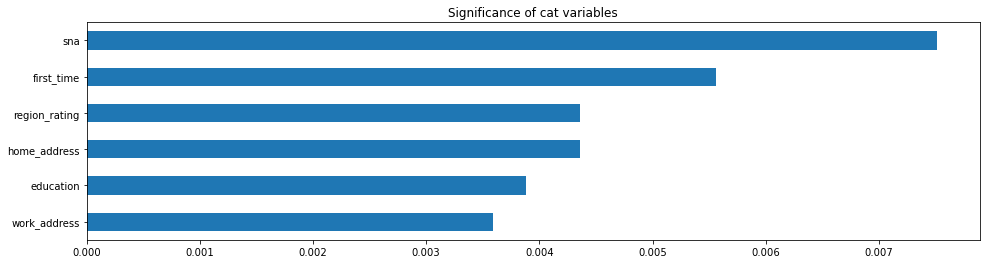

In [148]:
cat_cols_d = ['sna', 'first_time', 'region_rating',
              'home_address', 'education', 'work_address']
# Значимость категориальных признаков
imp_cat = pd.Series(mutual_info_classif(data[cat_cols_d],
                                        data['default'],
                                        discrete_features=True),
                    index=data[cat_cols_d].columns)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')
plt.title('Significance of cat variables')

## Значимость бинарных признаков

Text(0.5, 1.0, 'Significance of bin variables')

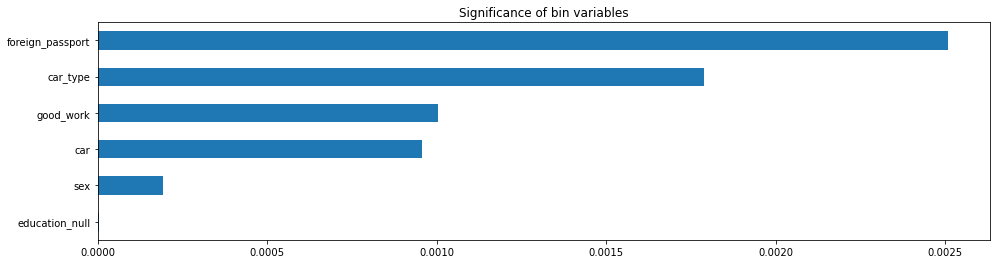

In [149]:
bin_cols_d = ['foreign_passport', 'car_type',
              'good_work', 'car', 'sex', 'education_null']

imp_bin = pd.Series(mutual_info_classif(data[bin_cols_d],
                                        data['default'],
                                        discrete_features=True),
                    index=data[bin_cols_d].columns)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')
plt.title('Significance of bin variables')

## Значимость непрерывных переменных

Text(0.5, 0, 'ignificance of num variables')

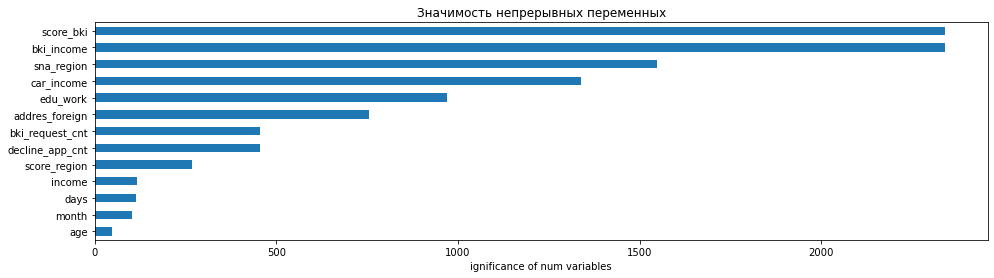

In [150]:
num_cols_d = ['score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income', 'days', 'sna_region', 'addres_foreign',
              'car_income', 'score_region',  'month', 'age', 'bki_income', 'edu_work']

imp_num = pd.Series(f_classif(data[num_cols_d], data['default'])[0],
                    index=data[num_cols_d].columns)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.title('Значимость непрерывных переменных')
plt.xlabel('ignificance of num variables')

Корреляции рассмотрим только для числовых столбцов. Посмотрим как числовые признаки коррелируют с наличием дефолта. Это поможет понять, какие параметры стоит оставить для модели, а какие — исключить.

<AxesSubplot:>

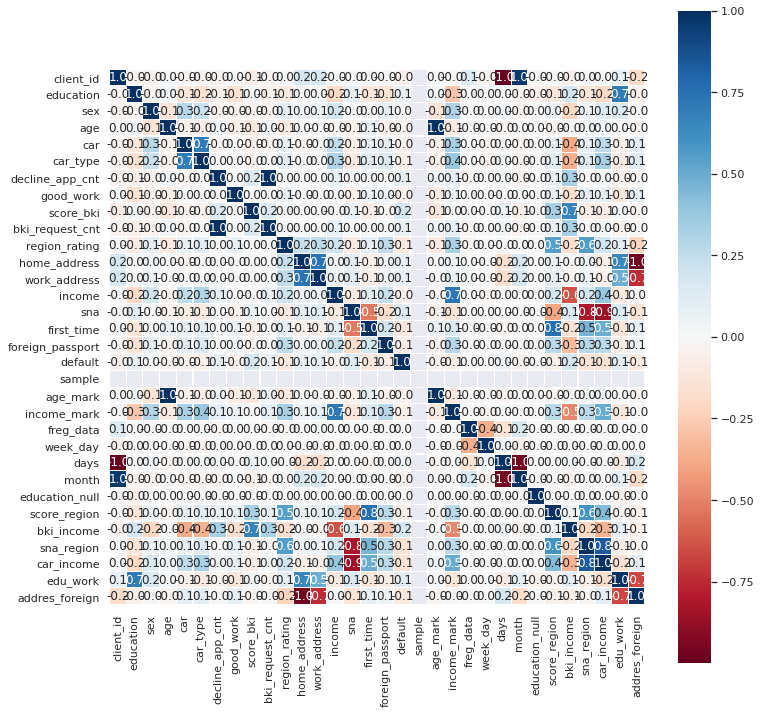

In [151]:
# проверим, нет ли мультиколлинеарности — сильной взаимосвязи между независимыми признаками.
# Для этого построим матрицу корреляций для признаков:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(data.corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

In [152]:
data_corr = data.corr()
data_corr['default'].sort_values(ascending=False)

default             1.000000
score_bki           0.175369
bki_income          0.175357
sna                 0.125832
edu_work            0.113905
home_address        0.084637
work_address        0.081582
bki_request_cnt     0.078242
decline_app_cnt     0.078242
education           0.074211
days                0.039372
sex                 0.019619
freg_data           0.005677
week_day            0.001069
education_null     -0.002521
age_mark           -0.024573
age                -0.025004
month              -0.037115
client_id          -0.039242
income             -0.039752
car                -0.043161
good_work          -0.043361
car_type           -0.057484
income_mark        -0.058292
score_region       -0.060068
foreign_passport   -0.066718
region_rating      -0.089035
addres_foreign     -0.100641
first_time         -0.105579
car_income         -0.133445
sna_region         -0.143348
sample                   NaN
Name: default, dtype: float64

**Вывод:** Можно заметить, что между возрастом, доходом и дефолтом есть обратная корреляция. Чем выше возраст, доход, тем меньше дефолтных кредитов.

## default - наличие дефолта (0 - нет, 1 - да)

In [153]:
# Очевидно что выборка распределена неравномерно и дефолтных клиентов заметно меньше
pd.DataFrame(data.default.value_counts())

,default
0,64427
1,9372


In [154]:
# Для устранения дисбаланса можно применить oversamping, но метрики оказались хуже
#train = data
#train_0 = data.query('default == 0')
#train_1 = data.query('default == 1')
#koeff = int(len(train_0)/len(train_1))
# for i in range(koeff):
#    train = train.append(train_1).reset_index(drop=True)  # объединяем

In [155]:
# train['default'].value_counts()

# 4. Подготовка данных к машинному обучению

In [156]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [157]:
# заново подгружаем данные
#df_train = pd.read_csv('train.csv', encoding='cp1251', sep=',')
#df_test = pd.read_csv('test.csv', encoding='cp1251', sep=',')

In [158]:
bin_cols = ['foreign_passport', 'car_type', 'freg_data',
            'good_work', 'car', 'sex']

cat_cols = ['sna', 'first_time', 'region_rating', 'month', 'week_day', 'decline_app_cnt', 'income_mark', 'age_mark',
            'home_address', 'education', 'work_address']

num_cols = ['score_bki', 'bki_request_cnt', 'income', 'age',
            'days', 'bki_income', 'sna_region', 'car_income', 'score_region']

bin_cols1 = ['foreign_passport', 'car_type', 'freg_data',
             'good_work', 'car', 'sex', 'sample', 'default']

In [159]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['default'] = 0

df = df_test.append(df_train, sort=False).reset_index(drop=True)  # объединяем

data = df_train

# если есть дублирующие строки,то удаляем, оставив последнее из дублирующихся наблюдений
df.drop_duplicates(keep='last')
# удаляем те строки, в которых все значения являются значениями NaN
df.dropna(how='all')
# попрощаемся со столбцами,  в которых все значения являются значениями NaN
df.dropna(how='all', axis=1)
# ----------------бинарные признаки---------------------------
# Обозначаем значения с M - мужской как 1, F - женский как ноль.
data['sex'] = data['sex'].apply(lambda x: 1 if x == 'M' else 0)
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'M' else 0)
# Обозначаем значения Y как 1, остальные как ноль.
data['car'] = data['car'].apply(lambda x: 1 if x == 'Y' else 0)
df['car'] = df['car'].apply(lambda x: 1 if x == 'Y' else 0)
# Обозначаем значения Y как 1, остальные как ноль.
data['car_type'] = data['car_type'].apply(lambda x: 1 if x == 'Y' else 0)
df['car_type'] = df['car_type'].apply(lambda x: 1 if x == 'Y' else 0)
# Обозначаем значения Y как 1, остальные как ноль.
data['foreign_passport'] = data['foreign_passport'].apply(
    lambda x: 1 if x == 'Y' else 0)
df['foreign_passport'] = df['foreign_passport'].apply(
    lambda x: 1 if x == 'Y' else 0)
# ----------------числовые признаки---------------------------
# добавим столбец по категориям возраста
data['age_mark'] = data.age.apply(mark_age)
df['age_mark'] = df.age.apply(mark_age)
# добавим столбец
data['income_mark'] = data.income.apply(mark_income)
df['income_mark'] = df.income.apply(mark_income)
# сместим баллы
m = df.score_bki.min()
df['score_bki'] = df['score_bki'] - m + 1
data['score_bki'] = data['score_bki'] - m + 1

# Создадим список из 12 самых частых дат
lst = list(df['app_date'].value_counts().index[:12])
# Расставим флаг с помощью лямбда-функции и проверим результат
df['freg_data'] = df['app_date'].apply(lambda x: 1 if x in lst else 0)
df['freg_data'].value_counts()

data['freg_data'] = data['app_date'].apply(lambda x: 1 if x in lst else 0)
data['freg_data'].value_counts()

# Конвертируем в более удобный формат даты
df.app_date = pd.to_datetime(df.app_date)
# по дням недели
df['week_day'] = df['app_date'].apply(lambda x: datetime.weekday(x))

# Количество дней, прошедших со дня подачи заявки
current_date = pd.to_datetime('27JAN2021')
df['days'] = (current_date - df.app_date).dt.days
df['month'] = df['app_date'].dt.month
m = df['days'].min()
df['days'] = df['days'] - m + 1

# Конвертируем в более удобный формат даты
data.app_date = pd.to_datetime(data.app_date)
data['week_day'] = data['app_date'].apply(lambda x: datetime.weekday(x))
# На основе признака app_date делаем новый признак
current_date = pd.to_datetime('27JAN2021')
# Количество дней, прошедших со дня подачи заявки
data['days'] = (current_date - data.app_date).dt.days
data['month'] = data['app_date'].dt.month
m = data['days'].min()
data['days'] = data['days'] - m + 1
# ----------------категориальные признаки---------------------------
# пока пропуски заполняем 'OTHER'
data['education'].fillna('OTHER', inplace=True)
df['education'].fillna('OTHER', inplace=True)
# Создаем новый признак. Обозначаю значения с пропусками как 1, остальные как ноль.
data['education_null'] = data['education'].apply(
    lambda x: 1 if x == 'OTHER' else 0)
df['education_null'] = df['education'].apply(
    lambda x: 1 if x == 'OTHER' else 0)
label_encoder = LabelEncoder()
mapped_education = pd.Series(label_encoder.fit_transform(data['education']))
data['education'] = label_encoder.fit_transform(data['education'])
data["education"].value_counts()
label_encoder = LabelEncoder()
mapped_education = pd.Series(label_encoder.fit_transform(df['education']))
df['education'] = label_encoder.fit_transform(df['education'])

In [160]:
# ----------------преобразования и новые признаки---------------------------
data['region_rating'] = data['region_rating'] / 10
data['age'] = data['age']/10
#data['decline_app_cnt'] = (data['decline_app_cnt']+1) / 10

data['decline_app_cnt1'] = data['decline_app_cnt'].apply(
    lambda x: 2 if x >= 3 else (1 if x > 0 else 0))

data['bki_request_cnt'] = (data['bki_request_cnt']+1) / 10
data['income'] = round(data['income'] / 100000, 4)
df['region_rating'] = df['region_rating'] / 10
df['age'] = df['age']/10

#df['decline_app_cnt'] = (df['decline_app_cnt'] + 1) / 10

df['decline_app_cnt1'] = df['decline_app_cnt'].apply(
    lambda x: 2 if x >= 3 else (1 if x > 0 else 0))

df['bki_request_cnt'] = (df['bki_request_cnt'] + 1) / 10
df['income'] = round(df['income'] / 100000, 4)
# ----------------
# создаем новый признак   0.187099
data['score_region'] = (
    data['score_bki'] * data['first_time'] * data['region_rating']) / 100
# заменяем бесконечные значения на 0
data['score_region'].replace([np.inf, -np.inf], 0, inplace=True)
# создаем новый признак   df
df['score_region'] = (df['score_bki'] * df['first_time']
                      * df['region_rating']) / 100
# заменяем бесконечные значения на 0
df['score_region'].replace([np.inf, -np.inf], 0, inplace=True)

# создаем новый признак   0.175357
data['bki_income'] = (11 + data['score_bki'] -
                      (3 + data['car'] + data['good_work'] +
                       data['foreign_passport']) / 3 - data['income'] + data['decline_app_cnt']) / 10
# заменяем бесконечные значения на 0
data['bki_income'].replace([np.inf, -np.inf], 0, inplace=True)
# создаем новый признак df
df['bki_income'] = (11 + df['score_bki'] -
                    (3 + df['car'] + df['good_work'] +
                     df['foreign_passport']) / 3 - df['income'] + df['decline_app_cnt']) / 10
# заменяем бесконечные значения на 0
df['bki_income'].replace([np.inf, -np.inf], 0, inplace=True)

# создаем новый признак  -0.143348
data['sna_region'] = data['region_rating'] / data['sna']
# заменяем бесконечные значения на 0
data['sna_region'].replace([np.inf, -np.inf], 0, inplace=True)
# создаем новый признак df
df['sna_region'] = df['region_rating'] / df['sna']
# заменяем бесконечные значения на 0
df['sna_region'].replace([np.inf, -np.inf], 0, inplace=True)
# создаем новый признак -0.132751
data['car_income'] = round(
    ((4 + data['car_type'] + data['income_mark']) / data['sna']) / 10, 4)
# заменяем бесконечные значения на 0
data['car_income'].replace([np.inf, -np.inf], 0, inplace=True)
# создаем новый признак df
df['car_income'] = round(
    ((4 + df['car_type'] + df['income_mark']) / df['sna']) / 10, 4)
# заменяем бесконечные значения на 0
df['car_income'].replace([np.inf, -np.inf], 0, inplace=True)

# Создаем новый признак.  -0.085003
#data_temp = data.query('income > 0')
#education_income_mean = data.groupby(['education'])['income'].mean()
#data['education_income_mean'] = data['education'].apply(lambda x: education_income_mean[x])

data['decline_app_cnt'] = data['decline_app_cnt1']
df['decline_app_cnt'] = df['decline_app_cnt1']

# удаляем
#data.drop('income_mark', axis=1, inplace=True)
#data.drop('age_mark', axis=1, inplace=True)
data.drop('app_date', axis=1, inplace=True)
#data.drop('sample', axis=1, inplace=True)
data.drop('decline_app_cnt1', axis=1, inplace=True)

# удаляем
#df.drop('income_mark', axis=1, inplace=True)
#df.drop('age_mark', axis=1, inplace=True)
df.drop('app_date', axis=1, inplace=True)
df.drop('decline_app_cnt1', axis=1, inplace=True)

train = data
# прологарифмируем
train['age'] = np.log(train['age'] + 1)
#train['decline_app_cnt'] = np.log(train['decline_app_cnt'] + 1)
train['bki_request_cnt'] = np.log(train['bki_request_cnt'] + 1)
train['income'] = np.log(train['income'] + 1)
# ---
train['sna_region'] = np.log(train['sna_region'] + 1)
train['car_income'] = np.log(train['car_income'] + 1)
train['bki_income'] = np.log(train['bki_income'] + 1)
train['score_region'] = np.log(train['score_region'] + 1)
# прологарифмируем df
df['age'] = np.log(df['age'] + 1)
#df['decline_app_cnt'] = np.log(df['decline_app_cnt'] + 1)
df['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)
df['income'] = np.log(df['income'] + 1)
# ---
df['sna_region'] = np.log(df['sna_region'] + 1)
df['car_income'] = np.log(df['car_income'] + 1)
df['bki_income'] = np.log(df['bki_income'] + 1)
df['score_region'] = np.log(df['score_region'] + 1)

In [161]:
# смотрим форму датафрейма
train.shape

(73799, 30)

In [162]:
df.shape

(110148, 30)

In [163]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()
for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])

In [164]:
# Для категориальных признаков мы будем использовать OneHotEncoder
train = pd.get_dummies(train, prefix=cat_cols, columns=cat_cols)

In [165]:
train[num_cols] = StandardScaler().fit_transform(train[num_cols].values)

In [166]:
X = train.drop(['default', 'client_id', 'sample', 'income', 'age', 'education_null'], axis=1)
Y = train.default.values

In [167]:
X.shape

(73799, 72)

In [168]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=RANDOM_SEED)

In [169]:
# проверяем
train.shape, Y.shape, X.shape, X_train.shape, X_test.shape

((73799, 78), (73799,), (73799, 72), (59039, 72), (14760, 72))

# 5. Оценка модели

**Подбор гиперпараметров (регуляризация)**

In [170]:
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for

Лучший penalty: l2
Лучшее C: 10000.0


In [171]:
# Обучим модель
model = LogisticRegression(penalty='l2', C=10000.0, max_iter=1000)
model.fit(X_train, y_train)

preds = model.predict(X_test)
probs = model.predict_proba(X_test)
probs = probs[:, 1]

print('Accuracy (доля правильных): %.5f' % accuracy_score(y_test, preds))
print('Precision (точность): %.5f' % precision_score(y_test, preds))
print('Recall (полнота): %.5f' % recall_score(y_test, preds))
print('F1: %.5f' % f1_score(y_test, preds))
print('ROC_AUC: %.5f' % roc_auc_score(y_test, probs))

Accuracy (доля правильных): 0.87466
Precision (точность): 0.40496
Recall (полнота): 0.02682
F1: 0.05031
ROC_AUC: 0.74513


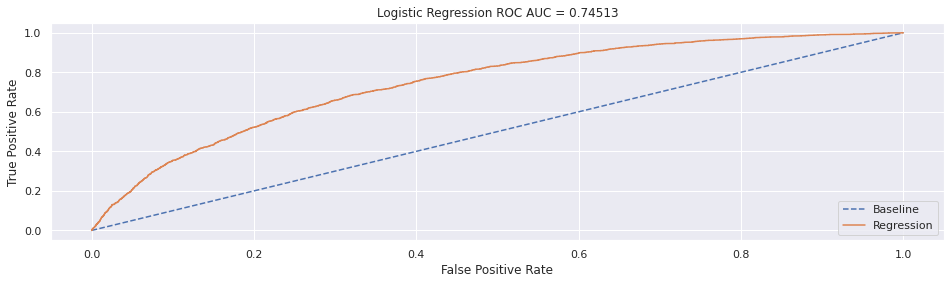

In [172]:
probs = model.predict_proba(X_test)
probs = model.predict_proba(X_test)
probs = probs[:, 1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

# Визуализация ROC AUC
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [173]:
# confusion matrix
# положительным исходом будет наличие дефолта у заемщика, отрицательным — отсутствие дефолта.
Y_predicted = model.predict(X_test)
cm = confusion_matrix(y_test, Y_predicted)
cm

array([[12861,    72],
       [ 1778,    49]])

<AxesSubplot:>

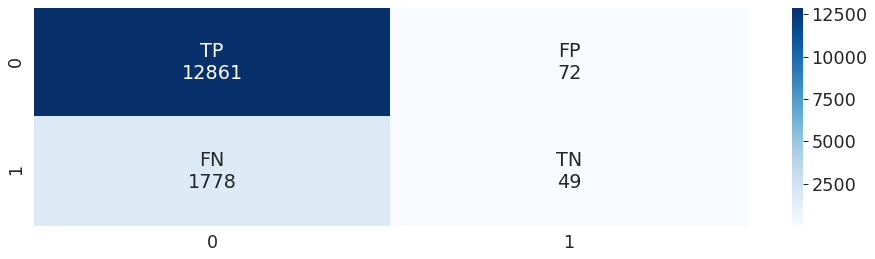

In [174]:
# визуализация confusion matrix
# TP истинно положительные (дефолт классифицирован как дефолт)
# FN ложно отрицательные (дефолт классифицирован как не-дефолт) ОШИБКА I РОДА
# FP ложно положительные (не-дефолт классифицирован как дефолт) ошибка II рода
# TN истинно отрицательные (не-дефолт классифицирован как не-дефолт)
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['TP', 'FP', 'FN', 'TN']
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

**Настройка гиперпараметров поиском по сетке**

In [175]:
# Настройка гиперпараметров поиском по сетке
model = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
epsilon_stop = 1e-4

param_grid = [
    {'penalty': ['l1'],
     'solver': ['liblinear', 'lbfgs'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
     'tol':[epsilon_stop]},
    {'penalty': ['none'],
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(
    model, param_grid, scoring='roc_auc', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

# печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))

preds = model.predict(X_test)
print('Accuracy (доля правильных): %.5f' % accuracy_score(y_test, preds))
print('Precision (точность): %.5f' % precision_score(y_test, preds))
print('Recall (полнота): %.5f' % recall_score(y_test, preds))
print('F1: %.5f' % f1_score(y_test, preds))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 1000
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l1'
	random_state: 42
	solver: 'liblinear'
	tol: 0.0001
	verbose: 0
	warm_start: False
Accuracy (доля правильных): 0.67060
Precision (точность): 0.22771
Recall (полнота): 0.69458
F1: 0.34297


**Печатаем метрики**
- **Accuracy ** — метрика для определения точности алгоритма, которая подсчитывает количество правильно предсказанных объектов к общему числу объектов.
- **precision** — метрика, измеряющая, насколько много из принятых моделью положительных объектов в действительности являются положительными.
- **recall** — метрика, измеряющая, насколько много положительных объектов из всех положительных объектов модель выбрала.
- **F1-score** — метрика, объединяющая precision и recall, является средним гармоническим между точностью и полнотой  

In [176]:
# Разделим данные :
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=RANDOM_SEED)

In [177]:
# модель на параметрах после первой оптимизации
model = LogisticRegression(C=1.0,
                           class_weight='balanced',
                           dual=False,
                           fit_intercept=True,
                           intercept_scaling=1,
                           l1_ratio=None,
                           max_iter=1000,
                           multi_class='auto',
                           n_jobs=None,
                           penalty='l1',
                           random_state=42,
                           solver='liblinear',
                           tol=0.0001,
                           verbose=0,
                           warm_start=False)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:, 1]
Y_predicted = model.predict(X_test)
preds = model.predict(X_test)
print('Accuracy (доля правильных): %.5f' % accuracy_score(y_test, preds))
print('Precision (точность): %.5f' % precision_score(y_test, preds))
print('Recall (полнота): %.5f' % recall_score(y_test, preds))
print('F1: %.5f' % f1_score(y_test, preds))
print('ROC_AUC: %.5f' % roc_auc_score(y_test, y_pred_prob))

Accuracy (доля правильных): 0.67060
Precision (точность): 0.22771
Recall (полнота): 0.69458
F1: 0.34297
ROC_AUC: 0.74499


In [178]:
cm = confusion_matrix(y_test, Y_predicted)
cm

array([[8629, 4304],
       [ 558, 1269]])

<AxesSubplot:>

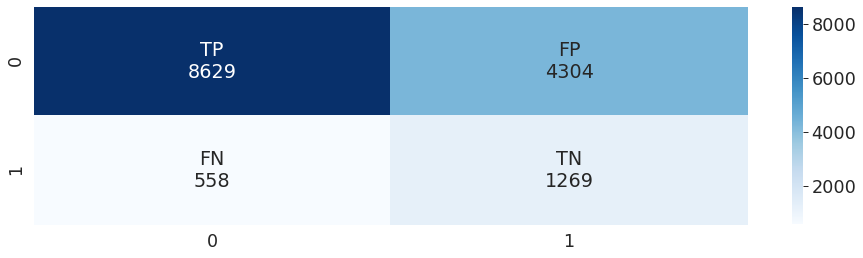

In [179]:
# визуализация confusion matrix
# TP истинно положительные (дефолт классифицирован как дефолт)
# FN ложно отрицательные (дефолт классифицирован как не-дефолт) ОШИБКА I РОДА
# FP ложно положительные (не-дефолт классифицирован как дефолт) ошибка II рода
# TN истинно отрицательные (не-дефолт классифицирован как не-дефолт)
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['TP', 'FP', 'FN', 'TN']
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

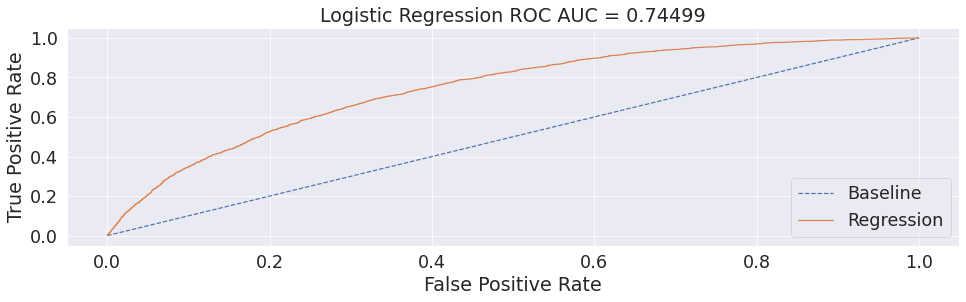

In [180]:
probs = model.predict_proba(X_test)
probs = probs[:, 1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

# Визуализация ROC AUC
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [181]:
df_coef = pd.DataFrame(np.hstack((np.array(X_train.columns).reshape(
  72, 1), model.coef_.reshape(72, 1))), columns = ['col', 'coef'])

In [182]:
#Составление списка признаков, отсортированного по значимости (абсолютному значению коэффициента)
df_coef['abs_coef'] = np.abs(df_coef.coef)
df_coef.sort_values(['abs_coef'], ascending = False)

,col,coef,abs_coef
49,income_mark_8,1.158521,1.158521
42,income_mark_1,-0.766146,0.766146
63,education_0,-0.687766,0.687766
13,sna_1,0.665304,0.665304
16,sna_4,-0.521801,0.521801
48,income_mark_7,0.520305,0.520305
15,sna_3,-0.498125,0.498125
4,score_bki,0.462526,0.462526
27,region_rating_8.0,-0.459138,0.459138
11,sna_region,-0.443261,0.443261


In [183]:
#Список эффективных признаков
lst_features = list(df_coef[df_coef['coef']!=0]['col'])
lst_features

['sex',
 'car',
 'car_type',
 'good_work',
 'score_bki',
 'bki_request_cnt',
 'foreign_passport',
 'freg_data',
 'days',
 'score_region',
 'bki_income',
 'sna_region',
 'car_income',
 'sna_1',
 'sna_3',
 'sna_4',
 'first_time_2',
 'first_time_3',
 'first_time_4',
 'region_rating_2.0',
 'region_rating_3.0',
 'region_rating_4.0',
 'region_rating_5.0',
 'region_rating_7.0',
 'region_rating_8.0',
 'month_1',
 'month_3',
 'month_4',
 'week_day_0',
 'week_day_2',
 'week_day_3',
 'week_day_4',
 'week_day_5',
 'week_day_6',
 'decline_app_cnt_0',
 'decline_app_cnt_1',
 'income_mark_1',
 'income_mark_2',
 'income_mark_3',
 'income_mark_5',
 'income_mark_6',
 'income_mark_7',
 'income_mark_8',
 'age_mark_1',
 'age_mark_2',
 'age_mark_3',
 'age_mark_4',
 'age_mark_6',
 'age_mark_7',
 'age_mark_8',
 'age_mark_9',
 'age_mark_10',
 'home_address_1',
 'home_address_2',
 'home_address_3',
 'education_0',
 'education_1',
 'education_3',
 'education_4',
 'education_5',
 'work_address_1',
 'work_address_2

## Submission

In [184]:
#### my_submission

In [185]:
# Для категориальных признаков мы будем использовать OneHotEncoder
df = pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

In [186]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

In [187]:
df[num_cols] = StandardScaler().fit_transform(df[num_cols].values)

In [188]:
df.shape

(110148, 78)

In [189]:
train_data = df.query('sample == 1').drop(
    ['sample', 'client_id', 'education_null','income','age'], axis=1)
test_data = df.query('sample == 0').drop(
    ['sample', 'client_id', 'education_null','income','age'], axis=1)

In [190]:
X_train = train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [191]:
# проверяем
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 73), (73799, 73), (73799, 72), (73799,), (36349, 72))

In [192]:
## Обучим модель
model = LogisticRegression(penalty='l2', C=10000.0, max_iter=1000)
model.fit(X_train, y_train)
#
y_pred_prob = model.predict_proba(X_test)[:, 1]
Y_predicted = model.predict(X_test)

In [193]:
# модель на параметрах после первой оптимизации  0.73880
#model = LogisticRegression(C=1.0,
#                           class_weight='balanced',
#                           dual=False,
#                           fit_intercept=True,
#                           intercept_scaling=1,
#                           l1_ratio=None,
#                           max_iter=1000,
#                           multi_class='auto',
#                           n_jobs=None,
#                           penalty='l1',
#                           random_state=42,
#                           solver='liblinear',
#                           tol=0.0001,
#                           verbose=0,
#                           warm_start=False)
#
#model.fit(X_train, y_train)
##
#y_pred_prob = model.predict_proba(X_test)[:, 1]
#Y_predicted = model.predict(X_test)

In [194]:
my_submit = pd.DataFrame(df_test.client_id)
my_submit['default'] = y_pred_prob
my_submit.to_csv('submission.csv', index=False)
my_submit.head(10)

,client_id,default
0,74835,0.033131
1,17527,0.284984
2,75683,0.060743
3,26883,0.080364
4,28862,0.029376
5,99881,0.129791
6,26630,0.318362
7,79934,0.034523
8,16605,0.030572
9,105449,0.023294
